In [1]:
import cv2
import argparse
import imutils
import time
import scipy.io
# from sklearn.svm import SVC
import skvideo.io
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from scipy.ndimage import morphology as mp
from skimage.feature import canny
from thundersvm import SVC
from random import sample
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import image
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
import mahotas
from imutils.video import VideoStream
from imutils.video import FPS
import os
import pickle
import copy

In [2]:
def playVideo(file):
    (major, minor) = cv2.__version__.split(".")[:2]

    OPENCV_OBJECT_TRACKERS = {
        "csrt": cv2.TrackerCSRT_create,
        "kcf": cv2.TrackerKCF_create,
        "boosting": cv2.TrackerBoosting_create,
        "mil": cv2.TrackerMIL_create,
        "tld": cv2.TrackerTLD_create,
        "medianflow": cv2.TrackerMedianFlow_create,
        "mosse": cv2.TrackerMOSSE_create
    }

    # grab the appropriate object tracker using our dictionary of
    # OpenCV object tracker objects
    tracker = OPENCV_OBJECT_TRACKERS["kcf"]()

    vs = cv2.VideoCapture(file)
    initBB = None
    # initialize the FPS throughput estimator
    fps = None
    
    boxes = {}
    
    # loop over frames from the video stream
    fno = 1
    delay=1
    while True:
        # grab the current frame, then handle if we are using a
        # VideoStream or VideoCapture object
        frame1 = vs.read()
        frame = frame1[1] # if args.get("video", False) else frame1
        # frame = fgbg.apply(frame)

        # check to see if we have reached the end of the stream
        if frame is None:
            break

        # resize the frame (so we can process it faster) and grab the
        # frame dimensions
        frame = imutils.resize(frame, width=500)
        (H, W) = frame.shape[:2]

        # check to see if we are currently tracking an object
        if initBB is not None:
            # grab the new bounding box coordinates of the object
            (success, box) = tracker.update(frame)

            # check to see if the tracking was a success
            if success:
                (x, y, w, h) = [int(v) for v in box]
                cv2.rectangle(frame, (x, y), (x + w, y + h),
                    (0, 255, 0), 2)
                boxes[fno]=[x,y,x+w,y+h]

            # update the FPS counter
            if fps is not None:
                fps.update()
                fps.stop()

                # initialize the set of information we'll be displaying on
                # the frame
                info = [
                    ("Tracker", "kcf"),
                    ("Success", "Yes" if success else "No"),
                    ("FPS", "{:.2f}".format(fps.fps())),
                ]
                
                if success:
                    delay=1
                else:
                    delay=10

                # loop over the info tuples and draw them on our frame
                for (i, (k, v)) in enumerate(info):
                    text = "{}: {}".format(k, v)
                    cv2.putText(frame, text, (10, H - ((i * 20) + 20)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        else:
            initBB = cv2.selectROI("Frame", frame, fromCenter=False,
                showCrosshair=True)
            print("Initial BBox: "+str(initBB))

            # start OpenCV object tracker using the supplied bounding box
            # coordinates, then start the FPS throughput estimator as well
            tracker.init(frame, initBB)
            fps = FPS().start()
        # show the output frame
        cv2.imshow("Frame", frame)
        key = cv2.waitKey(10) & 0xFF

        # if the 's' key is selected, we are going to "select" a bounding
        # box to track
        if key == ord("s"):
            # select the bounding box of the object we want to track (make
            # sure you press ENTER or SPACE after selecting the ROI)
            tracker = OPENCV_OBJECT_TRACKERS["kcf"]()
            initBB = None
            # initialize the FPS throughput estimator
            fps = None
            initBB = cv2.selectROI("Frame", frame, fromCenter=False,
                showCrosshair=True)
            print("Frame: "+str(fno)+" Selected BBox: "+str(initBB))

            # start OpenCV object tracker using the supplied bounding box
            # coordinates, then start the FPS throughput estimator as well
            tracker.init(frame, initBB)
            fps = FPS().start()

        # if the `q` key was pressed, break from the loop
        elif key == ord("q"):
            break

        fno=fno+1

    #         # if we are using a webcam, release the pointer
    #         if not args.get("video", False):
    #             vs.stop()

    #         # otherwise, release the file pointer
    #         else:

    vs.release()

    # close all windows
    cv2.destroyAllWindows()
    return boxes

In [3]:
def showBBoxes(file,boxes,label):
    vs = cv2.VideoCapture(file)
    
    # loop over frames from the video stream
    fno = 1
    
    while True:
        # grab the current frame, then handle if we are using a
        # VideoStream or VideoCapture object
        frame1 = vs.read()
        frame = frame1[1] # if args.get("video", False) else frame1
        # frame = fgbg.apply(frame)

        # check to see if we have reached the end of the stream
        if frame is None:
            break

        # resize the frame (so we can process it faster) and grab the
        # frame dimensions
        frame = imutils.resize(frame, width=500)
        (H, W) = frame.shape[:2]

        # check to see if we are currently tracking an object
        if fno in boxes:
            (x1,y1,x2,y2) = boxes[fno]
            cv2.rectangle(frame, (x1, y1), (x2, y2),
                        (0, 255, 0), 2)

        # show the output frame
        cv2.imshow("Class: "+str(label), frame)
        key = cv2.waitKey(20) & 0xFF

#         # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break

        fno=fno+1

    vs.release()

    # close all windows
    cv2.destroyAllWindows()
#     data={'X':X,'Y':Y}
#     return data

In [4]:
def predictSilhouette(next_img):
    next_patches = image.extract_patches_2d(next_img, (8, 8))
    TEST=[]
    for i in range(len(next_patches)):
        a = next_patches[i].flatten()
        TEST.append(a)
    predictions = svc.predict(TEST)
    mask = np.zeros_like(next_patches)
    for i in range(len(predictions)):
        if(predictions[i]==1):
            mask[i] = mask[i] + 1
    ## Using thresholding on the image
    reconstructed = []
    reconstructed = image.reconstruct_from_patches_2d(mask, next_img.shape)
#     plt.imshow(reconstructed),plt.show();
    ret,thresh1 = cv2.threshold(reconstructed,0.5,1,cv2.THRESH_BINARY)
#     plt.imshow(thresh1),plt.show();
    
    mask2 = thresh1.astype(np.bool)
    silhouette = np.zeros_like(next_img)
    silhouette[mask2] = next_img[mask2]
    
#     ## Using maximally connected components on the image
#     reconstructed = []
#     reconstructed = image.reconstruct_from_patches_2d(mask, next_img.shape)
#     plt.imshow(reconstructed),plt.show();
#     mask2 = reconstructed.astype(np.bool)
#     silhouette = np.zeros_like(next_img)
#     silhouette[mask2] = next_img[mask2]
    
#     gray_sil = cv2.cvtColor(silhouette, cv2.COLOR_BGR2GRAY)
#     connected_mask = undesired_objects(gray_sil)
#     stacked_img = np.stack((connected_mask,)*3, axis=-1)
    
#     plt.imshow(stacked_img),plt.show();
    
#     mask = stacked_img.astype(np.bool)
#     silhouette = np.zeros_like(next_img)
#     silhouette[mask] = next_img[mask]
    return silhouette

In [73]:
def trainVideo2(file,boxes,label,filename):
    vs = cv2.VideoCapture(file)
    
    # loop over frames from the video stream
    fno = 1
#     frame_array = []
    disp_flag=False
    capture=True
    next_frame=[]
    corners=[]
    img=[]
    storepath = 'output/'+str(label)+"/"
    nos = 100
    if not os.path.exists(storepath):
        os.mkdir(storepath)
#     fourcc = cv2.VideoWriter_fourcc(*'XVID')
#     fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
    fname = filename.strip('.mp4')
#     out = cv2.VideoWriter(storepath+fname+'.avi',fourcc, 10.0, (400,500))
    writer = skvideo.io.FFmpegWriter(storepath+fname+"_"+str(nos)+".mp4")
#     out = cv2.VideoWriter(storepath+filename,0x00000021, 10, (400,500))
    
    def mouse_click(event,x,y,flags,param):
        if event == cv2.EVENT_LBUTTONDOWN:
            corners.append([x,y])
            for i in corners:
                [x,y] = i
                cv2.circle(cropped_im,(x,y),3,255,-1)

#     cv2.namedWindow('Frame')
#     cv2.setMouseCallback("Frame", mouse_click)
    cur_no=0
    count = 1
    while True:
        # grab the current frame, then handle if we are using a
        # VideoStream or VideoCapture object
        frame1 = vs.read()
        frame = frame1[1] # if args.get("video", False) else frame1
        # frame = fgbg.apply(frame)

        # check to see if we have reached the end of the stream
        if frame is None:
            break

        # resize the frame (so we can process it faster) and grab the
        # frame dimensions
        frame = imutils.resize(frame, width=500)
        (H, W) = frame.shape[:2]

        # check to see if we are currently tracking an object
        if fno in boxes:
            (x1,y1,x2,y2) = boxes[fno]

            if x2<x1:
                temp=x2
                x2=x1
                x1=temp
            if y2<y1:
                temp=y2
                y2=y1
                y1=temp

            if x2>W:
                x2=W
            if y2>H:
                y2=H
            if x1<0:
                x1=0
            if y1<0:
                y1=0
            cropped_im = frame[y1:y2,x1:x2]
                
            # show the output frame
            key = cv2.waitKey(1) & 0xFF
            
#         # if the `q` key was pressed, break from the loop
            if key == ord("q"):
                break
            if key == ord('p'):
                img = copy.copy(cropped_im)
                while True:

                    key2 = cv2.waitKey(1) or 0xff
                    cv2.imshow('Frame',cropped_im)

                    if key2 == ord('p'):
                        disp_flag=True
                        break
            if disp_flag:

                mask = np.zeros((img.shape[0], img.shape[1]))
                cv2.fillConvexPoly(mask, np.array(corners), 1)
                cv2.imwrite('frame.png',img)
                cv2.imwrite('gt.png',mask)
#                 cv2.imshow("Mask:", mask)
                mask = mask.astype(np.bool)

                silhouette = np.zeros_like(img)
                silhouette[mask] = img[mask]
            
                 # delete zero columns
#                 silhouette= np.delete(silhouette,np.where(~silhouette.any(axis=0))[0], axis=1)
#                 # delete zero rows
#                 silhouette= np.delete(silhouette,np.where(~silhouette.any(axis=1))[0], axis=0)

                cv2.imwrite('extracted_silhouette.png',silhouette)
                disp_flag=False
                capture = True
#             [m,n,p] = cropped_im.shape
#             diff = 400 - m
#             top = int(diff/2)
#             bot = diff -top
#             diff = 500 - n
#             left = int(diff/2)
#             right = diff -left
#             constant= cv2.copyMakeBorder(cropped_im,top,bot,left,right,cv2.BORDER_CONSTANT,value=[0,0,0])
#             cv2.imshow("Frame", constant)
#             out.write(constant)
#             frame_array.append(constant)
            print("Frame:"+str(fno));
#             plt.imshow(cropped_im),plt.show();
            if(capture):
                next_img = predictFromHSV_Silhouette2(cropped_im)
                [m,n,p] = next_img.shape
                diff = 400 - m
                top = int(diff/2)
                bot = diff -top
                diff = 500 - n
                left = int(diff/2)
                right = diff -left
                padded_img= cv2.copyMakeBorder(next_img,top,bot,left,right,cv2.BORDER_CONSTANT,value=[0,0,0])
                padded_img = cv2.cvtColor(padded_img, cv2.COLOR_BGR2RGB)
                writer.writeFrame(padded_img)
#                 out.write(padded_img)
#                 plt.imshow(padded_img),plt.show();
                cur_no = cur_no+1
                if(cur_no>=nos):
                    count=count+1
                    nos=100*count
#                     capture=False
                    writer.close()
                    writer = skvideo.io.FFmpegWriter(storepath+fname+"_"+str(nos)+".mp4")
#                     out.release()
#                     break
#                 cv2.imshow("Silhouette:"+str(fno), padded_img)
#             plt.clf()

        fno=fno+1

    vs.release()
    writer.close()
#     out.release()
    
    # close all windows
#     cv2.destroyAllWindows()
#     data={'X':X,'Y':Y}
    return frame_array

In [6]:
svc = pickle.load(open('input/input1_svc.pkl', 'rb'))

In [7]:
basePath = "../IndianBirds/"
frame_array=[]
for i in range(22,23):
    boxes = {}
    fullPath = basePath+str(i)+"/"
    allfiles = os.listdir(fullPath)
    f = open(fullPath+"bbox-2.pkl","rb")
    boxes=pickle.load(f)
    f.close()
    j=0;
#     box = boxes[allfiles[0]][221]
    for file in allfiles:
#     for file in ["C3wkLDsVUwM.mp4"]:
        if file.endswith(".mp4"):
            frame_array = trainVideo2(fullPath+file,boxes[file],i,file)
            j=j+1
        if (j==1):
            break

Frame:2
Frame:3
Frame:4
Frame:5
Frame:6
Frame:7
Frame:8
Frame:9
Frame:10
Frame:11
Frame:12
Frame:13
Frame:14
Frame:15
Frame:16
Frame:17
Frame:18
Frame:19
Frame:20
Frame:21
Frame:22
Frame:23
Frame:24
Frame:25
Frame:26
Frame:27
Frame:28
Frame:29
Frame:30
Frame:31
Frame:32
Frame:33
Frame:34
Frame:35
Frame:36
Frame:37
Frame:38
Frame:39
Frame:40
Frame:41
Frame:42
Frame:43
Frame:44
Frame:45
Frame:46
Frame:47
Frame:48
Frame:49
Frame:50
Frame:51
Frame:52
Frame:53
Frame:54
Frame:55
Frame:56
Frame:57
Frame:58
Frame:59
Frame:60
Frame:61
Frame:62
Frame:63
Frame:64
Frame:65
Frame:66
Frame:67
Frame:68
Frame:69
Frame:70
Frame:71
Frame:72
Frame:73
Frame:74
Frame:75
Frame:76
Frame:77
Frame:78
Frame:79
Frame:80
Frame:81
Frame:82
Frame:83
Frame:84
Frame:85
Frame:86
Frame:87
Frame:88
Frame:89
Frame:90
Frame:91
Frame:92
Frame:93
Frame:94
Frame:95
Frame:96
Frame:97
Frame:98
Frame:99
Frame:100
Frame:101


In [36]:
np.unique(frame_array)

array([  0,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 18

In [7]:
for i in range(len(frame_array)):
    cv2.imshow("Frame:", frame_array[i])
    key = cv2.waitKey(20) & 0xFF
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
# close all windows
cv2.destroyAllWindows()

In [12]:
# writer = skvideo.io.FFmpegWriter("outputvideo.mp4")
# for i in range(len(frame_array)):
#         writer.writeFrame(frame_array[i])
# writer.close()

In [18]:
file = "output/22/B2X_Sj8KcZ0.avi"
vs = cv2.VideoCapture(file)

# loop over frames from the video stream
fno = 1

while True:
    # grab the current frame, then handle if we are using a
    # VideoStream or VideoCapture object
    frame1 = vs.read()
    frame = frame1[1] # if args.get("video", False) else frame1
    # frame = fgbg.apply(frame)
    print(frame)
    # check to see if we have reached the end of the stream
    if frame is None:
        break

    # resize the frame (so we can process it faster) and grab the
#     # frame dimensions
#     frame = imutils.resize(frame, width=500)
#     (H, W) = frame.shape[:2]

#     # check to see if we are currently tracking an object
#     if fno in boxes:
#         (x1,y1,x2,y2) = boxes[fno]
#         cv2.rectangle(frame, (x1, y1), (x2, y2),
#                     (0, 255, 0), 2)

    # show the output frame
    cv2.imshow("Frame:", frame)
    key = cv2.waitKey(20) & 0xFF

#         # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

    fno=fno+1

vs.release()

# close all windows
cv2.destroyAllWindows()

None


In [6]:
def trainVideo(file,boxes,label,filename):
    vs = cv2.VideoCapture(file)
    
    # loop over frames from the video stream
    fno = 1
    
    X=None
    Y=None
    disp_flag=False
    capture=False
    next_frame=[]
    corners=[]
    img=[]
    nos = 20
#     storepath = 'output/'+str(label)+"/"
# #     storepath="dataset/"+str(label)+"/"+filename
#     if not os.path.exists(storepath):
#         os.mkdir(storepath)
#     fourcc = cv2.VideoWriter_fourcc(*'XVID')
#     out = cv2.VideoWriter(storepath+filename,fourcc, 20.0, (400,500))
    def mouse_click(event,x,y,flags,param):
        if event == cv2.EVENT_LBUTTONDOWN:
            corners.append([x,y])
#             print("fno"+str(fno))
            for i in corners:
                [x,y] = i
#                 cropped_im[y,x]=255
                cv2.circle(cropped_im,(x,y),3,255,-1)
#     label=None
#     TEST=None
#     GT=None
#     storepath="dataset/"+str(label)+"/"+filename
#     if not os.path.exists("dataset/"+str(label)):
#         os.mkdir("dataset/"+str(label))
#     if not os.path.exists(storepath):
#         os.mkdir(storepath)
    cv2.namedWindow('Frame')
    cv2.setMouseCallback("Frame", mouse_click)
    while True:
        # grab the current frame, then handle if we are using a
        # VideoStream or VideoCapture object
        frame1 = vs.read()
        frame = frame1[1] # if args.get("video", False) else frame1
        # frame = fgbg.apply(frame)

        # check to see if we have reached the end of the stream
        if frame is None:
            break

        # resize the frame (so we can process it faster) and grab the
        # frame dimensions
        frame = imutils.resize(frame, width=500)
        (H, W) = frame.shape[:2]

        # check to see if we are currently tracking an object
        if fno in boxes:
            (x1,y1,x2,y2) = boxes[fno]
#             cv2.rectangle(frame, (x1, y1), (x2, y2),
#                         (0, 255, 0), 2)
            if x2<x1:
                temp=x2
                x2=x1
                x1=temp
            if y2<y1:
                temp=y2
                y2=y1
                y1=temp
#             print(frame.shape)
#             print(boxes[fno])
            if x2>W:
                x2=W
            if y2>H:
                y2=H
            if x1<0:
                x1=0
            if y1<0:
                y1=0
            cropped_im = frame[y1:y2,x1:x2]
            [m,n,p] = cropped_im.shape
            diff = 400 - m
            top = int(diff/2)
            bot = diff -top
            diff = 500 - n
            left = int(diff/2)
            right = diff -left
            constant= cv2.copyMakeBorder(cropped_im,top,bot,left,right,cv2.BORDER_CONSTANT,value=[0,0,0])
#             print(constant.shape);
            if(capture):
#                 next_img = predictSilhouette(cropped_im)
#                 [m,n,p] = next_img.shape
#                 diff = 400 - m
#                 top = int(diff/2)
#                 bot = diff -top
#                 diff = 500 - n
#                 left = int(diff/2)
#                 right = diff -left
#                 padded_img= cv2.copyMakeBorder(next_img,top,bot,left,right,cv2.BORDER_CONSTANT,value=[0,0,0])
#                 out.write(padded_img)

                cv2.imwrite('next_frame'+str(20-nos+1)+'.png',cropped_im)
                nos = nos-1
                if(nos==0):
                    capture=False

#             print(fno)
            if cropped_im is not None:
                f1 = fd_histogram(cropped_im)
                f2 = fd_haralick(cropped_im)
                f3 = fd_hu_moments(cropped_im)
                a=f1.tolist()
                b=np.zeros(len(a))
                for ind in range(len(a)):
                    b[ind] = a[ind][0]
                # global_feature = [f1,f2,f3]
                if max(b)!=0:
                    b = (b - min(b))/max(b)
                if max(f2)!=0:
                    f2 = (f2 - min(f2))/max(f2)
                if max(f3)!=0:
                    f3 = (f3 - min(f3))/max(f3)
                global_feature = np.hstack([b,f2,f3])
                if X is not None:
                    X.append(global_feature)
                else:
                    X=[global_feature]

                if Y is not None:
                    Y.append(label)
                else:
                    Y=[label]
                

            # show the output frame
#             cv2.imwrite(storepath+"/"+str(fno)+".png",cropped_im)
            key = cv2.waitKey(20) & 0xFF
            
#         # if the `q` key was pressed, break from the loop
            if key == ord("q"):
                break
            if key == ord('p'):
                img = copy.copy(cropped_im)
                while True:

                    key2 = cv2.waitKey(1) or 0xff
                    cv2.imshow('Frame',cropped_im)
                    
                    # cv2.imshow('frame', frame)

                    if key2 == ord('p'):
                        disp_flag=True
                        break
            if disp_flag:
#                 img = frame[y1:y2,x1:x2]
#                 plt.imshow(img),plt.show()
#                 img = newim
                mask = np.zeros((img.shape[0], img.shape[1]))
                bgdModel = np.zeros((1,65),np.float64)
                fgdModel = np.zeros((1,65),np.float64)
                cv2.fillConvexPoly(mask, np.array(corners), 1)
                cv2.imwrite('frame.png',img)
                cv2.imwrite('gt.png',mask)
#                 cv2.imshow("Mask:", mask)
                mask = mask.astype(np.bool)
#                 cv2.imshow("Mask:", mask)

                silhouette = np.zeros_like(img)
                silhouette[mask] = img[mask]
#                 # delete zero columns
#                 silhouette= np.delete(silhouette,np.where(~silhouette.any(axis=0))[0], axis=1)
#                 # delete zero rows
#                 silhouette= np.delete(silhouette,np.where(~silhouette.any(axis=1))[0], axis=0)
                
    
#                 mask = np.zeros_like(frame,np.uint8)
#                 rect = (x1,y1,x2-x1,y2-y1)
#                 cv2.grabCut(frame,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

#                 mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
# #                 mask2.resize(frame.shape)
#                 img = np.zeros([frame.shape[0],frame.shape[1],1,3])
#                 img = img*mask2[:,:,np.newaxis]

#                 mask = mask.astype(np.int8)
#                 mask = np.where((mask==255)|(mask==0),0,1).astype('uint8')
#                 mask, bgdModel, fgdModel = cv2.grabCut(img,mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)
#                 mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
#                 img = img*mask[:,:,np.newaxis]
#                 cv2.imshow("Grabcut:", img)
#                 cv2.namedWindow('Silhouette:')
                cv2.imwrite('extracted_silhouette.png',silhouette)
#                 cv2.imshow("Silhouette:", silhouette)
                disp_flag=False
                capture = True
#             gray = cv2.cvtColor(cropped_im,cv2.COLOR_BGR2GRAY)

#             corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
#             corners = np.int0(corners)
#             print (corners)
#             cv2.drawContours(cropped_im, corners, -1, (0, 255, 0), 3)
#             for i in corners:
#                 [x,y] = i
#                 cv2.circle(cropped_im,(x,y),3,255,-1)

#             plt.imshow(img),plt.show()
            cv2.imshow("Frame", cropped_im)
            
#             key = cv2.waitKey(1) & 0xFF

# #         # if the `q` key was pressed, break from the loop
#             if key == ord("q"):
#                 break

        fno=fno+1

    vs.release()
#     out.release()
    
    # close all windows
    cv2.destroyAllWindows()
    data={'X':X,'Y':Y}
    return data

In [7]:
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

def fd_haralick(image):    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    return haralick

def fd_histogram(image, mask=None):
    # convert the image to HSV color-space
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
#     # compute the color histogram
#     hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
#     # normalize the histogram
#     cv2.normalize(hist, hist)
#     hist.flatten()
    
    hsv_roi =  cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
    roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
    cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)
    return roi_hist

In [24]:
basePath = "../IndianBirds/"
X=None
Y=None
TEST=None
GT=None
for i in range(40,41):
    boxes = {}
    fullPath = basePath+str(i)+"/"
    allfiles = os.listdir(fullPath)
    f = open(fullPath+"bbox-2.pkl","rb")
    boxes=pickle.load(f)
    f.close()
    j=0;
#     box = boxes[allfiles[0]][221]
    for file in allfiles:
#     for file in ["C3wkLDsVUwM.mp4"]:
        if file.endswith(".mp4"):
            if(j==1):
                data = trainVideo(fullPath+file,boxes[file],i,file)
    #             if i==1:
                if X is not None:
                    X.append(data['X'])
                else:
                    X=data['X']

                if Y is not None:
                    Y.append(data['Y'])
                else:
                    Y=data['Y']
#             elif i==2:
#                 if TEST is not None:
#                     TEST.append(data['X'])
#                 else:
#                     TEST=data['X']

#                 if GT is not None:
#                     GT.append(data['Y'])
#                 else:
#                     GT=data['Y']
            j=j+1
        if (j==2):
            break
#         boxes[file] = b

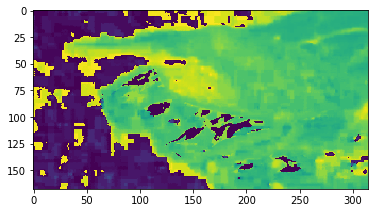

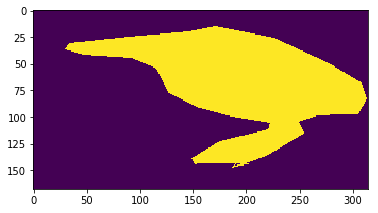

In [47]:
img = cv2.imread('input/frame.png');
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
img=img[:,:,0]
sil = cv2.imread('input/gt.png');
# sil = cv2.cvtColor(sil, cv2.COLOR_BGR2HSV)
sil=sil[:,:,0]
# [m,n] = img.shape
# [m1,n1] = sil.shape
# a=0
# b=0
# if(m1<m):
#     a = m 
plt.imshow(img),plt.show();
plt.imshow(sil*255),plt.show();
# cv2.imshow("Img",img);
# cv2.imshow("Sil",sil);
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [46]:
np.unique(sil)

array([0], dtype=uint8)

In [24]:
# sil=sil*255
# plt.imshow(sil),plt.show();

In [59]:
sil[:,:,0].shape

(168, 315)

In [62]:
np.unique(sil[:,:,2])

array([0, 1], dtype=uint8)

In [50]:
img[0:8,0:8].flatten()

array([33, 34, 39, 31, 32, 38, 30, 30, 37, 30, 30, 37, 30, 30, 37, 30, 30,
       37, 30, 30, 37, 30, 30, 37, 34, 35, 40, 33, 33, 39, 32, 32, 39, 32,
       32, 39, 32, 32, 39, 32, 32, 39, 32, 32, 39, 32, 32, 39, 34, 35, 40,
       34, 34, 40, 33, 33, 40, 33, 33, 40, 33, 33, 40, 33, 33, 40, 33, 33,
       40, 33, 33, 40, 35, 36, 41, 35, 35, 41, 34, 34, 41, 34, 34, 41, 34,
       34, 41, 34, 34, 41, 34, 34, 41, 34, 34, 41, 35, 36, 41, 36, 36, 42,
       35, 35, 42, 35, 35, 42, 35, 35, 42, 35, 35, 42, 35, 35, 42, 35, 35,
       42, 35, 37, 40, 36, 37, 42, 36, 36, 43, 36, 36, 43, 36, 36, 43, 36,
       36, 43, 36, 36, 43, 35, 35, 42, 33, 38, 38, 35, 38, 41, 36, 36, 43,
       36, 36, 43, 36, 36, 43, 36, 36, 43, 36, 36, 43, 34, 35, 42, 32, 37,
       36, 34, 37, 40, 36, 36, 43, 36, 36, 43, 36, 36, 43, 36, 36, 43, 36,
       36, 43, 34, 35, 41], dtype=uint8)

In [65]:
np.count_nonzero(sil[:,:,0])

16264

In [48]:
# im = img[0:8,0:8]
patches=[]
GT=[]
patches = image.extract_patches_2d(img, (8, 8))
GT = image.extract_patches_2d(sil, (8, 8))

In [114]:
patches.shape

(49588, 8, 8, 3)

In [62]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sil = cv2.cvtColor(sil, cv2.COLOR_BGR2GRAY)

In [116]:
i=0;
X1=None
Y1=[]
psize=8
[m,n,p] = img.shape
new_img = np.zeros([m,n,p])
# new_mask = np.zeros([m,n,p])
while i<(m-psize):
    j=0;
    while j<(n-psize):
        a = copy.copy(img[i:i+psize,j:j+psize])
        b = copy.copy(sil[i:i+psize,j:j+psize])
        new_img[i:i+psize,j:j+psize] = img[i:i+psize,j:j+psize];
#         new_img[i:i+psize,j:j+psize,0] = img[i:i+psize,j:j+psize,0];
#         new_img[i:i+psize,j:j+psize,1] = img[i:i+psize,j:j+psize,1];
#         new_img[i:i+psize,j:j+psize,2] = img[i:i+psize,j:j+psize,2];
        a = a.flatten()
        b = b.flatten()
        if X1 is None:
            X1 = a
        else:
            X1 = np.vstack([X1,a])
        if(np.count_nonzero(b)>=(psize*psize/2)):
            Y1.append(1)
        else:
            Y1.append(0)
        j=j+int(psize)
    i=i+int(psize)


In [117]:
X1.shape

(780, 192)

In [118]:
new_img.shape

(168, 315, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


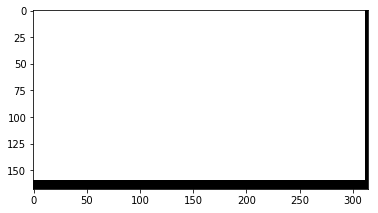

In [119]:
# gray = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
plt.imshow(new_img),plt.show();

In [90]:
np.array(Y1).shape

(190,)

In [72]:
Y1

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [20]:
# plt.imshow(new_img),plt.show();
# # cv2.imshow("Sil",new_img);
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()
# plt.imshow(new_mask*255),plt.show();

In [55]:
Y1

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [9]:
sil.shape

(168, 315, 3)

In [10]:
np.array(Y).shape

(20,)

In [84]:
X[0].shape[0]

768

In [67]:
patches.shape

(38908, 32, 32, 3)

In [17]:
len(GT)

38908

In [52]:
X=[]
Y=[]

In [53]:
i=0;
psize=8
print("Total Patches:"+str(len(patches)));
while i < len(patches):
#     print("Patch:"+str(i));
#     f1 = fd_histogram(patches[i])
#     f2 = fd_haralick(patches[i])
#     f3 = fd_hu_moments(patches[i])
#     a=f1.tolist()
#     b=np.zeros(len(a))
#     for ind in range(len(a)):
#         b[ind] = a[ind][0]
#     # global_feature = [f1,f2,f3]
#     if max(b)!=0:
#         b = (b - min(b))/max(b)
#     if max(f2)!=0:
#         f2 = (f2 - min(f2))/max(f2)
#     if max(f3)!=0:
#         f3 = (f3 - min(f3))/max(f3)
#     global_feature = np.hstack([b,f2,f3])
#     X.append(global_feature)
    

# for i in range(len(patches)):
    a = patches[i].flatten()
    if(np.count_nonzero(GT[i])>=(psize*psize/2)):
        Y.append(1)
    else:
        Y.append(0)

    X.append(a)
    i=i+1


Total Patches:49588


In [54]:
np.array(X).shape

(49588, 64)

In [62]:
embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(X)

MemoryError: 

In [64]:
embedding = LocallyLinearEmbedding(n_components=2)
X_transformed = embedding.fit_transform(X)

In [65]:
X_transformed.shape

(49588, 2)

In [50]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X1)

In [51]:
pca_result.shape

(49588, 6)

In [34]:
np.array(Y).shape

(49588,)

In [32]:
img[0:8,0:8].flatten().shape

(192,)

In [55]:
# svc = SVC(C=1,kernel='rbf',gamma=1/(X[0].shape[0]*np.array(X).var()))

In [79]:
ones = np.where(Y)[0]
num1 = int(0.8*len(ones))
zeroes = np.where(np.array(Y)==0)[0]
num2 = int(0.8*len(zeroes))
print(str(num1)+'/'+str(len(ones)))
print(str(num2)+'/'+str(len(zeroes)))

samp1 = sample(ones.tolist(),num1)
samp2 = sample(zeroes.tolist(),num2)

train_indices = np.array(samp1 + samp2)

test_X = np.delete(np.array(X),train_indices,axis=0)
test_Y = np.delete(Y,train_indices)
train_Y = np.array(Y)[train_indices.astype(int)]
train_X = np.array(X)[train_indices.astype(int)]

parameters = {'C':[1, 2, 3, 4, 5]}
# svc = SVC(gamma="scale")
svc = SVC(kernel='rbf',gamma=1/(train_X[0].shape[0]*np.array(train_X).var()))
clf = GridSearchCV(svc, parameters,scoring='accuracy', cv=5)


13056/16321
26613/33267


In [91]:
parameters = {'C':[80]}
svc = SVC(kernel='rbf',gamma=1/(train_X[0].shape[0]*np.array(train_X).var()))
clf = GridSearchCV(svc, parameters,scoring='accuracy', cv=5)

In [92]:
clf.fit(train_X,train_Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=None, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=4.412312573416967e-06,
  gpu_id=0, kernel='rbf', max_iter=-1, max_mem_size=-1, n_jobs=-1,
  probability=False, random_state=None, shrinking=False, tol=0.001,
  verbose=False),
       fit_params=None, iid='warn', n_jobs=None, param_grid={'C': [80]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [93]:
clf.cv_results_  

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([334.21693025]),
 'mean_score_time': array([10.33725038]),
 'mean_test_score': array([0.83309385]),
 'mean_train_score': array([0.86222238]),
 'param_C': masked_array(data=[80],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 80}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.83541273]),
 'split0_train_score': array([0.86156803]),
 'split1_test_score': array([0.8376607]),
 'split1_train_score': array([0.86182448]),
 'split2_test_score': array([0.83098059]),
 'split2_train_score': array([0.86258075]),
 'split3_test_score': array([0.82818606]),
 'split3_train_score': array([0.86255357]),
 'split4_test_score': array([0.83322829]),
 'split4_train_score': array([0.86258508]),
 'std_fit_time': array([15.0082892]),
 'std_score_time': array([1.19458642]),
 'std_test_score': array([0.00331067]),
 'std_train_score': array([0.0004373])}

In [90]:
clf.cv_results_  

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([226.60500579, 254.22473354]),
 'mean_score_time': array([ 9.77715397, 10.27653413]),
 'mean_test_score': array([0.82885881, 0.83158134]),
 'mean_train_score': array([0.85087221, 0.85685925]),
 'param_C': masked_array(data=[20, 40],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 20}, {'C': 40}],
 'rank_test_score': array([2, 1], dtype=int32),
 'split0_test_score': array([0.83100189, 0.83327032]),
 'split0_train_score': array([0.85041281, 0.85599042]),
 'split1_test_score': array([0.83274515, 0.83627426]),
 'split1_train_score': array([0.84988183, 0.8558374 ]),
 'split2_test_score': array([0.82455256, 0.82707336]),
 'split2_train_score': array([0.85167796, 0.85753899]),
 'split3_test_score': array([0.82516072, 0.82780789]),
 'split3_train_score': array([0.85165112, 0.85770103]),
 'split4_test_score': array([0.83083323, 0.8334804 ]),
 'split4_train_score': array([0.85073733, 0.85722838]),
 'std_fit_time': a

In [86]:
clf.cv_results_  

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([110.09150896, 149.5849546 , 170.97736945, 170.21837544,
        181.15070109]),
 'mean_score_time': array([ 6.17133441, 12.17476654, 10.49135919, 11.3723547 ,  9.85962129]),
 'mean_test_score': array([0.82295999, 0.82404396, 0.82439688, 0.8250271 , 0.82565731]),
 'mean_train_score': array([0.83595503, 0.83807254, 0.83973001, 0.84137487, 0.84259119]),
 'param_C': masked_array(data=[6, 7, 8, 9, 10],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 6}, {'C': 7}, {'C': 8}, {'C': 9}, {'C': 10}],
 'rank_test_score': array([5, 4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([0.82596093, 0.826339  , 0.82659105, 0.8273472 , 0.82772527]),
 'split0_train_score': array([0.83601185, 0.83765047, 0.83910002, 0.84042352, 0.84187307]),
 'split1_test_score': array([0.8265692 , 0.82757751, 0.82858583, 0.82921603, 0.83047643]),
 'split1_train_score': array([0.83466205, 0.83677328, 0.8382858 , 0.840

In [80]:
clf.fit(train_X,train_Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=None, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=4.412312573416967e-06,
  gpu_id=0, kernel='rbf', max_iter=-1, max_mem_size=-1, n_jobs=-1,
  probability=False, random_state=None, shrinking=False, tol=0.001,
  verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 2, 3, 4, 5]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [82]:
clf.cv_results_  

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([51.68862906, 51.45487056, 57.72186255, 57.80518723, 64.68202229]),
 'mean_score_time': array([7.30373669, 4.00252376, 3.94620199, 3.91766315, 3.88891301]),
 'mean_test_score': array([0.81353198, 0.8179939 , 0.81985934, 0.82099372, 0.82159873]),
 'mean_train_score': array([0.81752123, 0.82367214, 0.82799542, 0.83103305, 0.83362324]),
 'param_C': masked_array(data=[1, 2, 3, 4, 5],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1}, {'C': 2}, {'C': 3}, {'C': 4}, {'C': 5}],
 'rank_test_score': array([5, 4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([0.81398866, 0.81928166, 0.82142407, 0.82318841, 0.82444865]),
 'split0_train_score': array([0.81704166, 0.82394277, 0.82832293, 0.8308754 , 0.83390055]),
 'split1_test_score': array([0.81812453, 0.82203176, 0.82367028, 0.82392236, 0.8246786 ]),
 'split1_train_score': array([0.81666929, 0.82246731, 0.82656373, 0.82987238, 0.83255081]),

In [87]:
clf.best_params_

{'C': 10}

In [94]:
svc = SVC(C=10,kernel='rbf',gamma=1/(train_X[0].shape[0]*np.array(train_X).var()))
svc.fit(train_X,train_Y)

SVC(C=10, cache_size=None, class_weight={}, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=4.412312573416967e-06,
  gpu_id=0, kernel='rbf', max_iter=-1, max_mem_size=-1, n_jobs=-1,
  probability=False, random_state=None, shrinking=False, tol=0.001,
  verbose=False)

In [95]:
prediction = svc.predict(test_X)

In [96]:
score = accuracy_score(test_Y, prediction)
score

0.8316362536546023

In [120]:
svc = SVC(C=1,kernel='rbf',gamma='scale')
svc

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [97]:
# svc = SVC(C=1,kernel='rbf',gamma="scale")
# svc = SVC()
svc.fit(X,Y)
# train_predictions = svc.predict(val_X)

SVC(C=10, cache_size=None, class_weight={}, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=4.412312573416967e-06,
  gpu_id=0, kernel='rbf', max_iter=-1, max_mem_size=-1, n_jobs=-1,
  probability=False, random_state=None, shrinking=False, tol=0.001,
  verbose=False)

In [100]:
basePath = "../IndianBirds/"
frame_array=[]
for i in range(22,23):
    boxes = {}
    fullPath = basePath+str(i)+"/"
    allfiles = os.listdir(fullPath)
    f = open(fullPath+"bbox-2.pkl","rb")
    boxes=pickle.load(f)
    f.close()
    j=0;
#     box = boxes[allfiles[0]][221]
    for file in allfiles:
#     for file in ["C3wkLDsVUwM.mp4"]:
        if file.endswith(".mp4"):
#             if(j==1):
            frame_array = trainVideo2(fullPath+file,boxes[file],i,file)
            j=j+1
        if (j==1):
            break

NameError: name 'edgxfhcgjvhkbjl' is not defined

In [29]:
def undesired_objects (image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
    sizes = stats[:, -1]

    max_label = 1
    max_size = sizes[1]
    for i in range(2, nb_components):
        if sizes[i] > max_size:
            max_label = i
            max_size = sizes[i]

#     img2 = np.zeros(output.shape)
#     img2[output == max_label] = 255
#     plt.imshow(img2),plt.show();
    img2 = np.zeros(output.shape)
    img2[output == max_label] = 1
    return img2
#     cv2.imshow("Biggest component", img2)
#     cv2.waitKey()

In [229]:
psize

16

In [77]:
def predictFromHSV_Silhouette2(next_img):
    
    i=0;
    TEST1=None
    test_img = cv2.cvtColor(next_img, cv2.COLOR_BGR2HSV)
#     next_img = next_img[:,:,0]
#     psize=16
    psize=8
    [m,n,p] = next_img.shape
    while i<(m-psize):
        j=0;
        while j<(n-psize):
            a = copy.copy(test_img[i:i+psize,j:j+psize,0])
            a = a.flatten()
            if TEST1 is None:
                TEST1 = a
            else:
                TEST1 = np.vstack([TEST1,a])
            j=j+int(psize/2)
        i=i+int(psize/2)

    predictions = svc.predict(TEST1)

    i=0;
    k=0;
    [m,n,p] = next_img.shape
    new_mask = np.zeros([m,n,p])
    count = np.zeros([m,n,p])
    while i<(m-psize):
        j=0;
        while j<(n-psize):
            if k < len(predictions):
                if(predictions[k]==1):
                    new_mask[i:i+psize,j:j+psize] = new_mask[i:i+psize,j:j+psize] + 1
                    count[i:i+psize,j:j+psize] = count[i:i+psize,j:j+psize] + 1
                k = k+1
            j=j+int(psize/2)
        i=i+int(psize/2)

    count [count==0] = 1
    reconstructed1 = []
    reconstructed1 = new_mask/count
    ret,thresh1 = cv2.threshold(reconstructed1,0.5,1,cv2.THRESH_BINARY)
    print("Thresholded Mask:");
    plt.imshow(thresh1),plt.show();

#     mask1 = reconstructed1.astype(np.bool)
    mask1 = thresh1.astype(np.bool)
    silhouette1 = np.zeros_like(next_img)
    silhouette1[mask1] = next_img[mask1]
    print("Thresholded Silhouette:");
#     plt.imshow(silhouette1),plt.show();

    gray_sil = cv2.cvtColor(silhouette1, cv2.COLOR_BGR2GRAY)
    connected_mask = undesired_objects(gray_sil)
    
    stacked_img = np.stack((connected_mask,)*3, axis=-1)
    
#     plt.imshow(stacked_img),plt.show();
    
    mask = stacked_img.astype(np.bool)
    silhouette = np.zeros_like(next_img)
    silhouette[mask] = next_img[mask]
    plt.imshow(silhouette),plt.show();
    
#     edges = canny(connected_mask)
#     fill_holes = mp.binary_fill_holes(edges)

#     stacked_img = np.stack((fill_holes,)*3, axis=-1)
#     stacked_img = stacked_img.astype(float)
#     # type(stacked_img)
# #     print("Filled Mask:");
# #     plt.imshow(stacked_img),plt.show();

#     mask2 = stacked_img.astype(np.bool)
#     silhouette2 = np.zeros_like(next_img)
#     silhouette2[mask2] = next_img[mask2]
# #     print("Filled Silhouette:");
#     plt.imshow(silhouette2),plt.show();
    
    return silhouette

In [39]:
def predictSilhouette2(next_img):
    
    i=0;
    TEST1=None
#     psize=16
    # psize=4
    [m,n,p] = next_img.shape
    while i<(m-psize):
        j=0;
        while j<(n-psize):
            a = copy.copy(next_img[i:i+psize,j:j+psize])
            a = a.flatten()
            if TEST1 is None:
                TEST1 = a
            else:
                TEST1 = np.vstack([TEST1,a])
            j=j+int(psize/2)
        i=i+int(psize/2)

    predictions = svc.predict(TEST1)

    i=0;
    k=0;
    [m,n,p] = next_img.shape
    new_mask = np.zeros([m,n,p])
    count = np.zeros([m,n,p])
    while i<(m-psize):
        j=0;
        while j<(n-psize):
            if k < len(predictions):
                if(predictions[k]==1):
                    new_mask[i:i+psize,j:j+psize] = new_mask[i:i+psize,j:j+psize] + 1
                    count[i:i+psize,j:j+psize] = count[i:i+psize,j:j+psize] + 1
                k = k+1
            j=j+int(psize/2)
        i=i+int(psize/2)

    count [count==0] = 1
    reconstructed1 = []
    reconstructed1 = new_mask/count
    ret,thresh1 = cv2.threshold(reconstructed1,0.5,1,cv2.THRESH_BINARY)
    print("Thresholded Mask:");
    plt.imshow(thresh1),plt.show();

#     mask1 = reconstructed1.astype(np.bool)
    mask1 = thresh1.astype(np.bool)
    silhouette1 = np.zeros_like(next_img)
    silhouette1[mask1] = next_img[mask1]
    print("Thresholded Silhouette:");
#     plt.imshow(silhouette1),plt.show();

    gray_sil = cv2.cvtColor(silhouette1, cv2.COLOR_BGR2GRAY)
    connected_mask = undesired_objects(gray_sil)
    
    stacked_img = np.stack((connected_mask,)*3, axis=-1)
    
#     plt.imshow(stacked_img),plt.show();
    
    mask = stacked_img.astype(np.bool)
    silhouette = np.zeros_like(next_img)
    silhouette[mask] = next_img[mask]
    plt.imshow(silhouette),plt.show();
    
#     edges = canny(connected_mask)
#     fill_holes = mp.binary_fill_holes(edges)

#     stacked_img = np.stack((fill_holes,)*3, axis=-1)
#     stacked_img = stacked_img.astype(float)
#     # type(stacked_img)
# #     print("Filled Mask:");
# #     plt.imshow(stacked_img),plt.show();

#     mask2 = stacked_img.astype(np.bool)
#     silhouette2 = np.zeros_like(next_img)
#     silhouette2[mask2] = next_img[mask2]
# #     print("Filled Silhouette:");
#     plt.imshow(silhouette2),plt.show();
    
    return silhouette

###############################################################################

#     next_patches = image.extract_patches_2d(next_img, (8, 8))
#     TEST=[]
#     for i in range(len(next_patches)):
#         a = next_patches[i].flatten()
#         TEST.append(a)
#     predictions = svc.predict(TEST)
#     mask = np.zeros_like(next_patches)
#     for i in range(len(predictions)):
#         if(predictions[i]==1):
#             mask[i] = mask[i] + 1
# #     ## Using thresholding on the image
# #     reconstructed = []
# #     reconstructed = image.reconstruct_from_patches_2d(mask, next_img.shape)
# # #     plt.imshow(reconstructed),plt.show();
# #     ret,thresh1 = cv2.threshold(reconstructed,0.5,1,cv2.THRESH_BINARY)
# # #     plt.imshow(thresh1),plt.show();
    
# #     mask2 = thresh1.astype(np.bool)
# #     silhouette = np.zeros_like(next_img)
# #     silhouette[mask2] = next_img[mask2]
    
#     ## Using maximally connected components on the image
#     reconstructed = []
#     reconstructed = image.reconstruct_from_patches_2d(mask, next_img.shape)
#     plt.imshow(reconstructed),plt.show();
#     mask2 = reconstructed.astype(np.bool)
#     silhouette = np.zeros_like(next_img)
#     silhouette[mask2] = next_img[mask2]
    
#     gray_sil = cv2.cvtColor(silhouette, cv2.COLOR_BGR2GRAY)
#     connected_mask = undesired_objects(gray_sil)
#     stacked_img = np.stack((connected_mask,)*3, axis=-1)
    
#     plt.imshow(stacked_img),plt.show();
    
#     mask = stacked_img.astype(np.bool)
#     silhouette = np.zeros_like(next_img)
#     silhouette[mask] = next_img[mask]
#     return silhouette

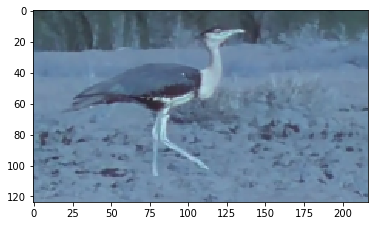

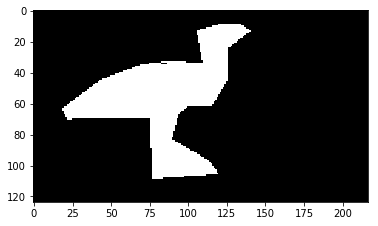

In [10]:
######### Training with stride 8 ############
img = cv2.imread('frame.png');
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sil = cv2.imread('gt.png');
# sil = cv2.cvtColor(sil, cv2.COLOR_BGR2GRAY)

plt.imshow(img),plt.show();
plt.imshow(sil*255),plt.show();

i=0;
X1=None
Y1=[]
psize=16
[m,n,p] = img.shape
new_img = np.zeros([m,n,p])
# new_mask = np.zeros([m,n,p])
while i<(m-psize):
    j=0;
    while j<(n-psize):
        a = copy.copy(img[i:i+psize,j:j+psize])
        b = copy.copy(sil[i:i+psize,j:j+psize])
        new_img[i:i+psize,j:j+psize] = img[i:i+psize,j:j+psize];
        a = a.flatten()
        b = b.flatten()
        if X1 is None:
            X1 = a
        else:
            X1 = np.vstack([X1,a])
        if(np.count_nonzero(b)>=(psize*psize/2)):
            Y1.append(1)
        else:
            Y1.append(0)
        j=j+int(psize/4)
    i=i+int(psize/4)
    
# svc = SVC(C=1,kernel='rbf',gamma='scale')
# svc = SVC(C=5,kernel='rbf',gamma=1/(X1[0].shape[0]*np.array(X1).var()))
# # svc
# svc.fit(X1,Y1)

In [25]:
svc

SVC(C=5, cache_size=None, class_weight={}, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=1.2986707847799133e-06,
  gpu_id=0, kernel='rbf', max_iter=-1, max_mem_size=-1, n_jobs=-1,
  probability=False, random_state=None, shrinking=False, tol=0.001,
  verbose=False)

In [27]:
svc = SVC(C=5,kernel='rbf',gamma=1/(X[0].shape[0]*np.array(X).var()))
svc.fit(X,Y)

SVC(C=5, cache_size=None, class_weight={}, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=1.2969276829233e-06,
  gpu_id=0, kernel='rbf', max_iter=-1, max_mem_size=-1, n_jobs=-1,
  probability=False, random_state=None, shrinking=False, tol=0.001,
  verbose=False)

In [99]:
basePath = "../IndianBirds/"
frame_array=[]
for i in range(40,41):
    boxes = {}
    fullPath = basePath+str(i)+"/"
    allfiles = os.listdir(fullPath)
    f = open(fullPath+"bbox-2.pkl","rb")
    boxes=pickle.load(f)
    f.close()
    j=0;
#     box = boxes[allfiles[0]][221]
    for file in allfiles:
#     for file in ["C3wkLDsVUwM.mp4"]:
        if file.endswith(".mp4"):
            if(j==1):
                frame_array = trainVideo2(fullPath+file,boxes[file],i,file)
            j=j+1
        if (j==2):
            break

NameError: name 'gxfhcgjvhj' is not defined

Input Image:


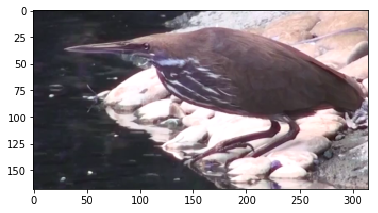

Thresholded Mask:


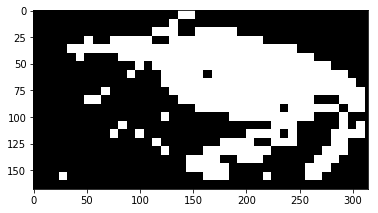

Thresholded Silhouette:


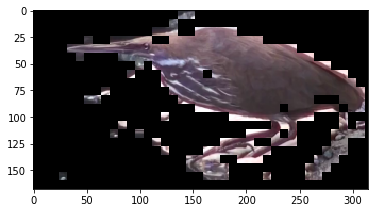

Filled Mask:


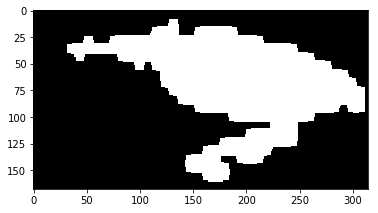

Filled Silhouette:


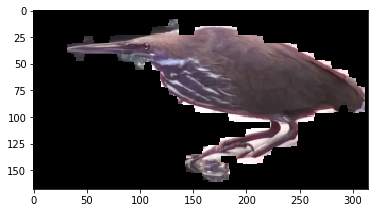

In [137]:
############### Testing with Stride 8 #####################
n=1
next_img = cv2.imread('input1/next_frame'+str(n)+'.png');
# next_img = cv2.cvtColor(next_img, cv2.COLOR_BGR2GRAY)
print("Input Image:");
plt.imshow(next_img),plt.show();

i=0;
TEST1=None
# psize=4
[m,n,p] = next_img.shape
while i<(m-psize):
    j=0;
    while j<(n-psize):
        a = copy.copy(next_img[i:i+psize,j:j+psize])
        a = a.flatten()
        if TEST1 is None:
            TEST1 = a
        else:
            TEST1 = np.vstack([TEST1,a])
        j=j+int(psize)
    i=i+int(psize)
    
predictions = svc.predict(TEST1)

i=0;
k=0;
# psize=8
[m,n,p] = next_img.shape
new_mask = np.zeros([m,n,p])
count = np.zeros([m,n,p])
while i<(m-psize):
    j=0;
    while j<(n-psize):
        if(predictions[k]==1):
            new_mask[i:i+psize,j:j+psize] = new_mask[i:i+psize,j:j+psize] + 1
            count[i:i+psize,j:j+psize] = count[i:i+psize,j:j+psize] + 1
        k = k+1
        j=j+int(psize)
    i=i+int(psize)
    
count [count==0] = 1
reconstructed1 = []
reconstructed1 = new_mask/count
ret,thresh1 = cv2.threshold(reconstructed1,0.5,1,cv2.THRESH_BINARY)
# plt.imshow(reconstructed1),plt.show();
print("Thresholded Mask:");
plt.imshow(thresh1),plt.show();

mask1 = reconstructed1.astype(np.bool)
silhouette1 = np.zeros_like(next_img)
silhouette1[mask1] = next_img[mask1]
print("Thresholded Silhouette:");
plt.imshow(silhouette1),plt.show();

gray_sil = cv2.cvtColor(silhouette1, cv2.COLOR_BGR2GRAY)
connected_mask = undesired_objects(gray_sil)
edges = canny(connected_mask)
fill_holes = mp.binary_fill_holes(edges)

stacked_img = np.stack((fill_holes,)*3, axis=-1)
stacked_img = stacked_img.astype(float)
# type(stacked_img)
print("Filled Mask:");
plt.imshow(stacked_img),plt.show();

mask2 = stacked_img.astype(np.bool)
silhouette2 = np.zeros_like(next_img)
silhouette2[mask2] = next_img[mask2]
print("Filled Silhouette:");
plt.imshow(silhouette2),plt.show();

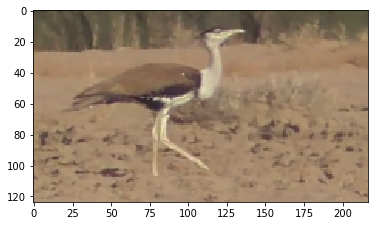

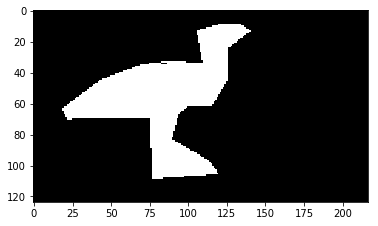

Total Patches:22018


In [9]:
img = cv2.imread('frame.png');

sil = cv2.imread('gt.png');
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img),plt.show();
plt.imshow(sil*255),plt.show();

patches=[]
GT=[]
psize=16
patches = image.extract_patches_2d(img, (psize, psize))
GT = image.extract_patches_2d(sil, (psize, psize))

X=[]
Y=[]

i=0;
print("Total Patches:"+str(len(patches)));
while i < len(patches):

# for i in range(len(patches)):
    a = patches[i].flatten()
    if(np.count_nonzero(GT[i])>=(psize*psize/2)*3):
        Y.append(1)
    else:
        Y.append(0)

    X.append(a)
    i=i+1
    
# svc = SVC(C=1,kernel='rbf',gamma='scale')
# svc = SVC(C=1,kernel='rbf',gamma=1/(X[0].shape[0]*np.array(X).var()))
# svc.fit(X,Y)

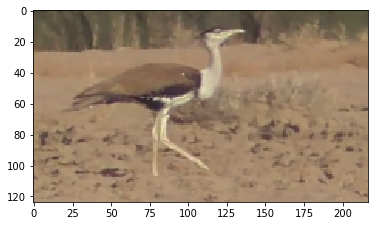

In [56]:
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img),plt.show();

In [68]:
########## Cross Validation with 80% positive samples and 80%negative samples ################
n=5
l=int(len(X)/n)+1
count=1
for i in range(0, len(X), l):
    print("Fold "+str(count))
    count+=1
    train_X = None
    train_Y = None
    if(i-1>0):
        train_X = X[0:i-1]+X[i+l+1:len(X)]
        train_Y = Y[0:i-1]+Y[i+l+1:len(X)]
    else:
        train_X = X[i + l+1:len(X)]
        train_Y = Y[i + l+1:len(X)]
#     c = list(zip(train_X,train_Y))
#     shuffle(c)
#     shuffled_train_data,shuffled_train_labels = zip(*c)
    
    parameters = {'C':[1, 10]}
#     svc = SVC(gamma="scale")
    svc = SVC(kernel='rbf',gamma=1/(train_X[0].shape[0]*np.array(train_X).var()))
    clf = GridSearchCV(svc, parameters,scoring='accuracy', cv=5)
    clf.fit(train_X,train_Y)
    
    best_parameters = clf.best_params_  
    print("Best Parameters: "+str(best_parameters))
    
    best_score = clf.best_score_
    print("Best Score: "+str(best_score))

Fold 1
Best Parameters: {'C': 1}
Best Score: 0.8863907341168455
Fold 2
Best Parameters: {'C': 10}
Best Score: 0.8585055643879174
Fold 3
Best Parameters: {'C': 1}
Best Score: 0.8677606177606177
Fold 4
Best Parameters: {'C': 1}
Best Score: 0.8253463547581195
Fold 5
Best Parameters: {'C': 1}
Best Score: 0.8208912858359353


In [69]:
results = clf.cv_results_  
print("Best Parameters: "+str(results))

Best Parameters: {'mean_fit_time': array([  60.25681596, 4193.84805474]), 'std_fit_time': array([  10.16465639, 8256.9874154 ]), 'mean_score_time': array([2.56112828, 1.7779346 ]), 'std_score_time': array([0.34660207, 0.40167557]), 'param_C': masked_array(data=[1, 10],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1}, {'C': 10}], 'split0_test_score': array([0.65664018, 0.63904654]), 'split1_test_score': array([0.79279024, 0.74936134]), 'split2_test_score': array([0.94805563, 0.92137383]), 'split3_test_score': array([0.81720125, 0.78399092]), 'split4_test_score': array([0.88983532, 0.85065304]), 'mean_test_score': array([0.82089129, 0.78887312]), 'std_test_score': array([0.09870367, 0.09530111]), 'rank_test_score': array([1, 2], dtype=int32), 'split0_train_score': array([0.97870981, 0.99503229]), 'split1_train_score': array([0.97934999, 0.99630996]), 'split2_train_score': array([0.97445359, 0.99524553]), 'split3_train_score': array(

In [70]:
results

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([  60.25681596, 4193.84805474]),
 'mean_score_time': array([2.56112828, 1.7779346 ]),
 'mean_test_score': array([0.82089129, 0.78887312]),
 'mean_train_score': array([0.98116646, 0.99630992]),
 'param_C': masked_array(data=[1, 10],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1}, {'C': 10}],
 'rank_test_score': array([1, 2], dtype=int32),
 'split0_test_score': array([0.65664018, 0.63904654]),
 'split0_train_score': array([0.97870981, 0.99503229]),
 'split1_test_score': array([0.79279024, 0.74936134]),
 'split1_train_score': array([0.97934999, 0.99630996]),
 'split2_test_score': array([0.94805563, 0.92137383]),
 'split2_train_score': array([0.97445359, 0.99524553]),
 'split3_test_score': array([0.81720125, 0.78399092]),
 'split3_train_score': array([0.9834658 , 0.99666477]),
 'split4_test_score': array([0.88983532, 0.85065304]),
 'split4_train_score': array([0.98985312, 0.99829703]),
 'std_fit_time': arr

In [74]:
parameters = {'C':[1, 2, 3, 4, 5]}
# svc = SVC(gamma="scale")
svc = SVC(kernel='rbf',gamma=1/(X[0].shape[0]*np.array(X).var()))
clf = GridSearchCV(svc, parameters,scoring='accuracy', cv=5)
# clf.fit(X,Y)

In [75]:
clf

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=None, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=1.2969276829233e-06,
  gpu_id=0, kernel='rbf', max_iter=-1, max_mem_size=-1, n_jobs=-1,
  probability=False, random_state=None, shrinking=False, tol=0.001,
  verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 2, 3, 4, 5]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [76]:
clf.fit(X,Y)

KeyboardInterrupt: 

In [204]:
np.count_nonzero(Y)

4346

In [205]:
np.where(np.array(Y)==0)[0]

array([    0,     1,     2, ..., 22015, 22016, 22017])

In [10]:
ones = np.where(Y)[0]
num1 = int(0.8*len(ones))
zeroes = np.where(np.array(Y)==0)[0]
num2 = int(0.8*len(zeroes))
print(str(num1)+'/'+str(len(ones)))
print(str(num2)+'/'+str(len(zeroes)))

3476/4346
14137/17672


In [15]:
samp1 = sample(ones.tolist(),num1)
samp2 = sample(zeroes.tolist(),num2)

In [16]:
train_indices = np.array(samp1 + samp2)

In [12]:
samp1 = np.array(samp1)

In [13]:
samp2 = np.array(samp2)

In [139]:
np.unique(ones)

array([  515,   516,   517, ..., 20281, 20282, 20283])

In [212]:
len(Y)

22018

In [213]:
len(test_Y)

4405

In [214]:
len(test_X)

4405

In [17]:
test_X = np.delete(np.array(X),train_indices,axis=0)

In [18]:
test_Y = np.delete(Y,train_indices)

In [19]:
train_Y = np.array(Y)[train_indices.astype(int)]

In [20]:
train_X = np.array(X)[train_indices.astype(int)]

In [21]:
train_X.shape

(17613, 768)

In [225]:
parameters = {'C':[1, 2, 3, 4, 5]}
# svc = SVC(gamma="scale")
svc = SVC(kernel='rbf',gamma=1/(train_X[0].shape[0]*np.array(train_X).var()))
clf = GridSearchCV(svc, parameters,scoring='accuracy', cv=5)
clf.fit(train_X,train_Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=None, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=1.2949282511210312e-06,
  gpu_id=0, kernel='rbf', max_iter=-1, max_mem_size=-1, n_jobs=-1,
  probability=False, random_state=None, shrinking=False, tol=0.001,
  verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 2, 3, 4, 5]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [226]:
clf.cv_results_  

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:1

{'mean_fit_time': array([48.85559602, 49.74494214, 58.94517303, 64.32701197, 71.08168449]),
 'mean_score_time': array([3.17444472, 2.89411917, 2.80311141, 2.75171905, 2.69917097]),
 'mean_test_score': array([0.967013  , 0.97234997, 0.97666496, 0.97927667, 0.98097996]),
 'mean_train_score': array([0.97047634, 0.97737466, 0.98230002, 0.98488333, 0.98644467]),
 'param_C': masked_array(data=[1, 2, 3, 4, 5],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1}, {'C': 2}, {'C': 3}, {'C': 4}, {'C': 5}],
 'rank_test_score': array([5, 4, 3, 2, 1], dtype=int32),
 'split0_test_score': array([0.96679909, 0.97105562, 0.97729852, 0.9792849 , 0.98070375]),
 'split0_train_score': array([0.97011853, 0.97650649, 0.9827525 , 0.98481085, 0.98623039]),
 'split1_test_score': array([0.97019586, 0.97558899, 0.97842748, 0.98098212, 0.98211751]),
 'split1_train_score': array([0.96997871, 0.97835344, 0.98261178, 0.98523776, 0.98658623]),

In [227]:
clf.best_params_

{'C': 5}

In [22]:
svc = SVC(C=5,kernel='rbf',gamma=1/(train_X[0].shape[0]*np.array(train_X).var()))
svc.fit(train_X,train_Y)

SVC(C=5, cache_size=None, class_weight={}, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=1.2986707847799133e-06,
  gpu_id=0, kernel='rbf', max_iter=-1, max_mem_size=-1, n_jobs=-1,
  probability=False, random_state=None, shrinking=False, tol=0.001,
  verbose=False)

In [23]:
prediction = svc.predict(test_X)

In [24]:
score = accuracy_score(test_Y, prediction)
score

0.9836549375709421

Frame:20


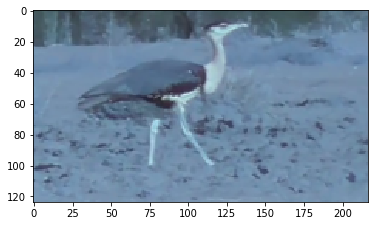

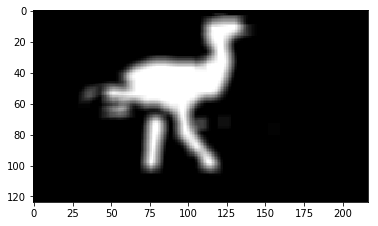

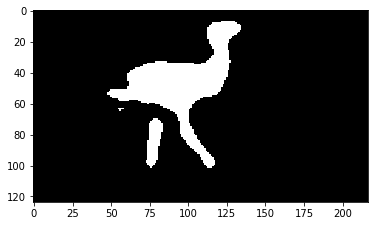

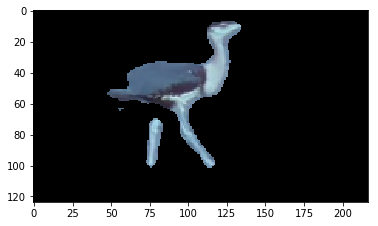

In [35]:
##### Testing for stride 1 ########
for n in range(20,21):
    print("Frame:"+str(n));
    next_img = cv2.imread('next_frame'+str(n)+'.png');
    plt.imshow(next_img),plt.show();
    
    next_patches = image.extract_patches_2d(next_img, (psize, psize))
    TEST=[]
    for i in range(len(next_patches)):
        a = next_patches[i].flatten()
        TEST.append(a)
    predictions = svc.predict(TEST)
    mask = np.zeros_like(next_patches)
    for i in range(len(predictions)):
        if(predictions[i]==1):
            mask[i] = mask[i] + 1
    ## Using thresholding on the image
    reconstructed = []
    reconstructed = image.reconstruct_from_patches_2d(mask, next_img.shape)
    plt.imshow(reconstructed),plt.show();
    ret,thresh1 = cv2.threshold(reconstructed,0.6,1,cv2.THRESH_BINARY)
    plt.imshow(thresh1),plt.show();
    
    mask2 = thresh1.astype(np.bool)
    silhouette = np.zeros_like(next_img)
    silhouette[mask2] = next_img[mask2]
    
    ## Using maximally connected components on the image
#     reconstructed = []
#     reconstructed = image.reconstruct_from_patches_2d(mask, next_img.shape)
#     plt.imshow(reconstructed),plt.show();
#     mask2 = reconstructed.astype(np.bool)
#     silhouette = np.zeros_like(next_img)
#     silhouette[mask2] = next_img[mask2]
    
#     gray_sil = cv2.cvtColor(silhouette, cv2.COLOR_BGR2GRAY)
#     connected_mask = undesired_objects(gray_sil)
#     stacked_img = np.stack((connected_mask,)*3, axis=-1)
    
#     plt.imshow(stacked_img),plt.show();
    
#     mask = stacked_img.astype(np.bool)
#     silhouette = np.zeros_like(next_img)
#     silhouette[mask] = next_img[mask]
    
    plt.imshow(silhouette),plt.show();
    cv2.imwrite('silhouette_frame'+str(n)+'.png',silhouette);

In [189]:
f = open("input/"+"input1_svc.pkl","wb")
pickle.dump(svc,f)
f.close()

In [41]:
f = open("output/40/"+"vid2_svc.pkl","wb")
pickle.dump(svc,f)
f.close()

PicklingError: Can't pickle <class 'thundersvm.thundersvm.c_int_Array_1'>: attribute lookup c_int_Array_1 on thundersvm.thundersvm failed

In [42]:
svc.save_to_file("output/40/"+"vid2_svc.pkl")

In [45]:
svc

SVC(C=1, cache_size=None, class_weight={}, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=5.091138519998705e-06,
  gpu_id=0, kernel='rbf', max_iter=-1, max_mem_size=-1, n_jobs=-1,
  probability=False, random_state=None, shrinking=False, tol=0.001,
  verbose=False)

In [6]:
svc = SVC()

In [7]:
svc

SVC(C=1.0, cache_size=None, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', gpu_id=0,
  kernel='rbf', max_iter=-1, max_mem_size=-1, n_jobs=-1, probability=False,
  random_state=None, shrinking=False, tol=0.001, verbose=False)

In [8]:
svc.load_from_file("output/40/"+"vid2_svc.pkl")

In [9]:
svc

SVC(C=1.0, cache_size=None, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma=5.09113988300669e-06,
  gpu_id=0, kernel=b'rbf', max_iter=-1, max_mem_size=-1, n_jobs=-1,
  probability=0, random_state=None, shrinking=False, tol=0.001,
  verbose=False)

In [174]:
predictions.shape

(66258,)

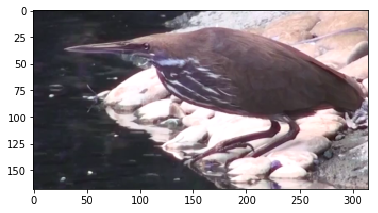

In [122]:
n=1
next_img = cv2.imread('input1/next_frame'+str(n)+'.png');
# next_img = cv2.cvtColor(next_img, cv2.COLOR_BGR2GRAY)
plt.imshow(next_img),plt.show();

In [123]:
psize

8

In [74]:
next_img = cv2.cvtColor(next_img, cv2.COLOR_BGR2GRAY)

In [42]:
next_patches = image.extract_patches_2d(next_img, (psize, psize))
TEST=[]
i=0
print("Total Patches:"+str(len(next_patches)));
# for i in range(len(next_patches)):
while i < len(next_patches):
    a = next_patches[i].flatten()
    
#     print("Patch:"+str(i));
#     f1 = fd_histogram(next_patches[i])
#     f2 = fd_haralick(next_patches[i])
#     f3 = fd_hu_moments(next_patches[i])
#     a=f1.tolist()
#     b=np.zeros(len(a))
#     for ind in range(len(a)):
#         b[ind] = a[ind][0]
#     # global_feature = [f1,f2,f3]
#     if max(b)!=0:
#         b = (b - min(b))/max(b)
#     if max(f2)!=0:
#         f2 = (f2 - min(f2))/max(f2)
#     if max(f3)!=0:
#         f3 = (f3 - min(f3))/max(f3)
#     global_feature = np.hstack([b,f2,f3])
#     TEST.append(global_feature)
    
    TEST.append(a)
    i=i+1

Total Patches:49588


In [43]:
pca = PCA(n_components=3)
TEST_pca = pca.fit_transform(TEST)

In [124]:
i=0;
TEST1=None
# psize=4
[m,n,p] = next_img.shape
while i<(m-psize):
    j=0;
    while j<(n-psize):
        a = copy.copy(next_img[i:i+psize,j:j+psize])
        a = a.flatten()
        if TEST1 is None:
            TEST1 = a
        else:
            TEST1 = np.vstack([TEST1,a])
        j=j+int(psize)
    i=i+int(psize)

In [125]:
TEST1.shape

(780, 192)

In [126]:
predictions = svc.predict(TEST1)

In [64]:
svc

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
next_patches.shape

(45900, 16, 16, 3)

In [74]:
# s = accuracy_score(Y, predictions)
# s

0.8780148423005566

In [76]:
# rfc = RandomForestClassifier()
# rfc.fit(X,Y)
# train_predictions = rfc.predict(TEST)
# s = accuracy_score(Y, train_predictions)
# print("Score:"+str(s))

Score:0.8780148423005566


In [81]:
# knn = KNeighborsClassifier(16)
# knn.fit(X,Y)
# train_predictions = knn.predict(TEST)
# accuracy_score(Y, train_predictions)
# print("Score:"+str(s))

Score:0.8780148423005566


In [ ]:
# bdt = AdaBoostClassifier(svc,
#                          algorithm="SAMME",
#                          n_estimators=200)
# bdt.fit(X, Y)

In [20]:
# train_predictions = bdt.predict(TEST)
# s = accuracy_score(Y, train_predictions)
# print("Score:"+str(s))

NameError: name 'bdt' is not defined

In [80]:
# bdt = AdaBoostClassifier(rfc,
#                          algorithm="SAMME",
#                          n_estimators=200)
# bdt.fit(X, Y)
# train_predictions = bdt.predict(TEST)
# s = accuracy_score(Y, train_predictions)
# print("Score:"+str(s))

Score:0.8780148423005566


In [107]:
# train_predictions = bdt.predict(TEST)
# s = accuracy_score(Y, train_predictions)
# print("Score:"+str(s))

In [127]:
i=0;
k=0;
# psize=8
[m,n,p] = next_img.shape
new_mask = np.zeros([m,n,p])
count = np.zeros([m,n,p])
while i<(m-psize):
    j=0;
    while j<(n-psize):
        if(predictions[k]==1):
            new_mask[i:i+psize,j:j+psize] = new_mask[i:i+psize,j:j+psize] + 1
            count[i:i+psize,j:j+psize] = count[i:i+psize,j:j+psize] + 1
        k = k+1
        j=j+int(psize)
    i=i+int(psize)



In [128]:
count [count==0] = 1

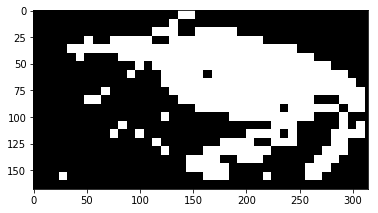

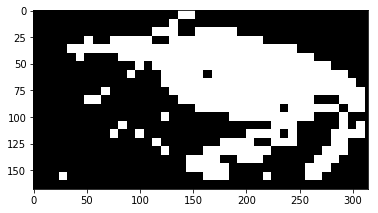

In [129]:
reconstructed1 = []
reconstructed1 = new_mask/count
ret,thresh1 = cv2.threshold(reconstructed1,0.5,1,cv2.THRESH_BINARY)
plt.imshow(reconstructed1),plt.show();
plt.imshow(thresh1),plt.show();

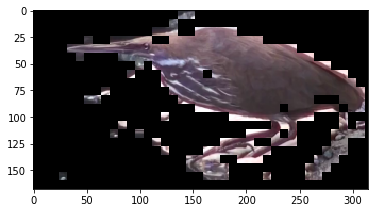

In [130]:
mask1 = reconstructed1.astype(np.bool)
silhouette1 = np.zeros_like(next_img)
silhouette1[mask1] = next_img[mask1]
plt.imshow(silhouette1),plt.show();

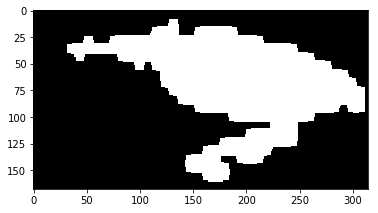

In [131]:
gray_sil = cv2.cvtColor(silhouette1, cv2.COLOR_BGR2GRAY)
connected_mask = undesired_objects(gray_sil)
edges = canny(connected_mask)
fill_holes = mp.binary_fill_holes(edges)

stacked_img = np.stack((fill_holes,)*3, axis=-1)
stacked_img = stacked_img.astype(float)
# type(stacked_img)
plt.imshow(stacked_img),plt.show();

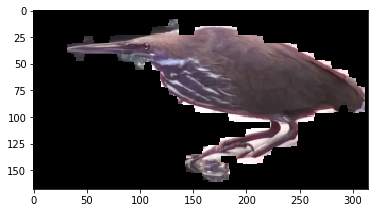

In [132]:
mask2 = stacked_img.astype(np.bool)
silhouette2 = np.zeros_like(next_img)
silhouette2[mask2] = next_img[mask2]
plt.imshow(silhouette2),plt.show();

In [54]:
# a = np.ones([8,8])
# b = np.zeros([8,8])
# mask = np.array([],dtype='uint8')
mask = np.zeros_like(next_patches)
for i in range(len(predictions)):
    if(predictions[i]==1):
        mask[i] = mask[i] + 1

In [57]:
#GT.shape
reconstructed=[]

In [55]:
reconstructed=[]
reconstructed = image.reconstruct_from_patches_2d(mask, next_img.shape)

In [56]:
# a,b,c = next_img.shape
# reconstructed = reconstructed[0:a,0:b,0:c]

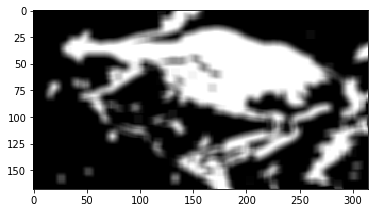

In [57]:
plt.imshow(reconstructed),plt.show();

In [259]:
mask2.shape

(168, 315, 3)

In [260]:
next_img.shape

(168, 315, 3)

In [58]:
mask2 = reconstructed.astype(np.bool)
silhouette = np.zeros_like(next_img)
silhouette[mask2] = next_img[mask2]

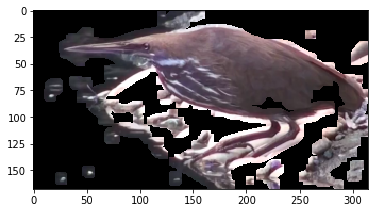

In [59]:
plt.imshow(silhouette),plt.show();
# cv2.imwrite('silhouette_frame'+str(n)+'.png',silhouette);

In [231]:
np.unique(reconstructed)

array([0.      , 0.015625, 0.03125 , 0.046875, 0.0625  , 0.078125,
       0.09375 , 0.109375, 0.125   , 0.140625, 0.15625 , 0.171875,
       0.1875  , 0.203125, 0.21875 , 0.234375, 0.25    , 0.265625,
       0.28125 , 0.296875, 0.3125  , 0.328125, 0.34375 , 0.359375,
       0.375   , 0.390625, 0.40625 , 0.421875, 0.4375  , 0.453125,
       0.46875 , 0.484375, 0.5     , 0.515625, 0.53125 , 0.546875,
       0.5625  , 0.578125, 0.59375 , 0.609375, 0.625   , 0.640625,
       0.65625 , 0.671875, 0.6875  , 0.703125, 0.71875 , 0.734375,
       0.75    , 0.765625, 0.78125 , 0.796875, 0.8125  , 0.828125,
       0.84375 , 0.859375, 0.875   , 0.890625, 0.90625 , 0.921875,
       0.9375  , 0.953125, 0.96875 , 0.984375, 1.      ])

In [34]:
ret,thresh1 = cv2.threshold(reconstructed,0.7,1,cv2.THRESH_BINARY)

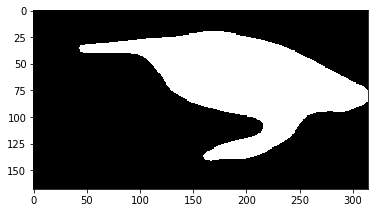

In [35]:
# plt.imshow(ret),plt.show();
plt.imshow(thresh1),plt.show();

In [36]:
mask2 = thresh1.astype(np.bool)

silhouette = np.zeros_like(next_img)
silhouette[mask2] = next_img[mask2]

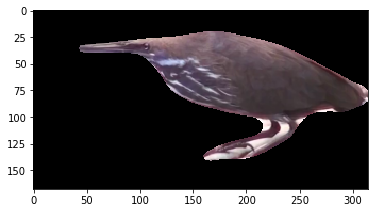

In [37]:
plt.imshow(silhouette),plt.show();
# cv2.imwrite('silhouette_frame'+str(n)+'.png',silhouette);

In [263]:
gray_sil = cv2.cvtColor(silhouette, cv2.COLOR_BGR2GRAY)
connected_mask = undesired_objects(gray_sil)

In [264]:
stacked_img = np.stack((connected_mask,)*3, axis=-1)
# backtorgb = cv2.cvtColor(connected_mask,cv2.COLOR_GRAY2RGB)

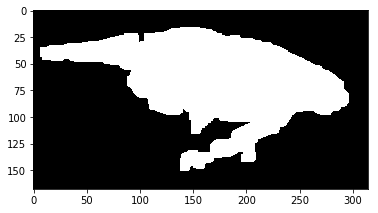

In [265]:
plt.imshow(stacked_img),plt.show();

In [266]:
mask = stacked_img.astype(np.bool)

silhouette = np.zeros_like(next_img)
silhouette[mask] = next_img[mask]

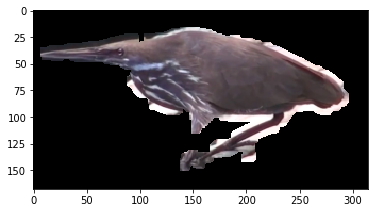

In [267]:
plt.imshow(silhouette),plt.show();

In [268]:
cv2.imwrite('silhouette_frame'+str(n)+'.png',silhouette);

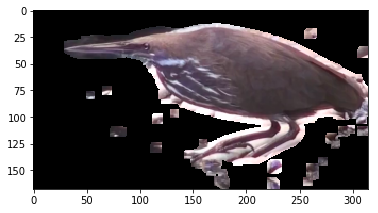

In [28]:
plt.imshow(silhouette),plt.show();
# cv2.imshow("Sil",silhouette);
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
# svc = SVC(C=9,kernel='poly',probability=True)
# svc.fit(X,Y)
# svc.fit(patches[0],np.vstack([np.zeros([4,1]),np.ones([4,1])]))
# train_predictions = svc.predict(val_X)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [13]:
train_X = np.array(X)
train_Y = np.array(Y)

In [14]:
train_X.shape

(49588, 64)

In [15]:
train_Y.shape

(49588,)

In [61]:
[m,n] = train_X.shape
train_X = train_X.reshape(n,m)
train_Y = train_Y.reshape(n,m)

ValueError: not enough values to unpack (expected 2, got 0)

In [18]:
svc = SVC(C=9,kernel='poly',probability=True)
# svc.fit(patches[0],train_Y[0:8])
svc.fit(patches[0],np.vstack([np.zeros([4,1]),np.ones([4,1])]))
# train_predictions = svc.predict(val_X)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=9, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [25]:
patches[0].flatten()

array([39, 38, 37, 35, 35, 35, 35, 33, 39, 38, 36, 35, 35, 35, 35, 33, 37,
       37, 36, 36, 35, 35, 35, 33, 33, 35, 36, 35, 35, 35, 35, 33, 33, 35,
       35, 35, 35, 35, 35, 33, 33, 35, 33, 33, 33, 33, 33, 35, 33, 35, 33,
       33, 33, 33, 33, 35, 33, 33, 33, 33, 33, 33, 33, 35], dtype=uint8)

In [20]:
y = np.vstack([np.zeros([4,1]),np.ones([4,1])])
y.shape

(8, 1)

In [144]:
np.zeros([8,1])

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [8]:
img[0:4][0:4].shape

(4, 315)

In [10]:
img[0:8,0:8].flatten()

array([35, 35, 33, 32, 32, 33, 33, 33, 35, 35, 33, 32, 32, 33, 33, 33, 35,
       35, 33, 32, 32, 33, 33, 33, 35, 35, 33, 32, 32, 33, 33, 33, 35, 35,
       33, 33, 33, 33, 33, 33, 35, 36, 35, 35, 35, 34, 33, 33, 35, 36, 36,
       36, 35, 34, 33, 33, 36, 36, 36, 36, 36, 34, 33, 33], dtype=uint8)

In [25]:
basePath = "../IndianBirds/"

for i in range(40,41):
    boxes = {}
    fullPath = basePath+str(i)+"/"
    allfiles = os.listdir(fullPath)
    if not allfiles:
        continue
    f = open(fullPath+"bbox-2.pkl","rb")
#     f = open(fullPath+"bbox.pkl","rb")
    boxes=pickle.load(f)
    f.close()
    j=0;
#     for j in range(2):
#     for j in range(len(allfiles)):
#         file = allfiles[j];
#     box = boxes[allfiles[0]][221]
    for file in allfiles:
        if file.endswith(".mp4"):
            showBBoxes(fullPath+file,boxes[file],i)
            j=j+1
        if (j==2):
            break
#         boxes[file] = b

In [5]:
basePath = "../IndianBirds/"
fullPath = basePath+str(10)+"/"
allfiles = os.listdir(fullPath)
len(allfiles)
allfiles

['bbox-2.pkl',
 'jZhVmNWkxj0.mp4',
 'dgji_Ncm6SM.mp4',
 'JL5G9kM64jM.mp4',
 'W_NwdwDlYIc.mp4',
 'sn5yo9qWaOU.mp4']

In [10]:
basePath = "../IndianBirds/"

for i in range(40,41):
    boxes = {}
    fullPath = basePath+str(i)+"/"
    allfiles = os.listdir(fullPath)
    j=0;
#     for j in range(2):
#     for j in range(len(allfiles)):
#         file = allfiles[j];
    for file in allfiles:
        if file.endswith(".mp4"):
            b = playVideo(fullPath+file)
            boxes[file] = b
            j=j+1
            if (j==2):
                break
    f = open(fullPath+"bbox-2.pkl","wb")
    pickle.dump(boxes,f)
    f.close()

Initial BBox: (0, 0, 0, 0)
Frame: 129 Selected BBox: (166, 151, 98, 91)
Frame: 241 Selected BBox: (201, 130, 106, 97)
Frame: 305 Selected BBox: (225, 122, 135, 92)
Frame: 355 Selected BBox: (277, 83, 118, 83)
Frame: 981 Selected BBox: (0, 0, 0, 0)
Frame: 1219 Selected BBox: (62, 136, 111, 77)
Frame: 1408 Selected BBox: (0, 0, 0, 0)
Initial BBox: (0, 0, 0, 0)
Frame: 77 Selected BBox: (204, 106, 169, 118)
Frame: 446 Selected BBox: (0, 0, 0, 0)
Frame: 475 Selected BBox: (128, 71, 273, 122)
Frame: 681 Selected BBox: (296, 21, 204, 136)
Frame: 733 Selected BBox: (175, 63, 217, 124)
Frame: 864 Selected BBox: (0, 0, 0, 0)
Frame: 1026 Selected BBox: (211, 84, 161, 129)
Frame: 1433 Selected BBox: (183, 74, 139, 118)
Frame: 1523 Selected BBox: (211, 74, 153, 120)
Frame: 1676 Selected BBox: (0, 0, 0, 0)
Frame: 1874 Selected BBox: (200, 71, 100, 121)
Frame: 2414 Selected BBox: (173, 81, 111, 142)
Frame: 2999 Selected BBox: (267, 64, 133, 124)
Frame: 3494 Selected BBox: (0, 0, 0, 0)
Frame: 3571 Sel

In [19]:
img = np.random.rand(500,500)

In [32]:
img[1:100][1:100]

array([[0.87516638, 0.21197162, 0.45360931, ..., 0.93687633, 0.63356946,
        0.5272329 ],
       [0.97241954, 0.98465435, 0.14020151, ..., 0.29676441, 0.49880665,
        0.0599615 ],
       [0.73966181, 0.42396878, 0.09193496, ..., 0.29373374, 0.90361751,
        0.38109981],
       ...,
       [0.50311951, 0.8938899 , 0.33397294, ..., 0.17806126, 0.40292823,
        0.33236798],
       [0.94010311, 0.46568317, 0.98278704, ..., 0.97448993, 0.2404963 ,
        0.63512798],
       [0.76205937, 0.82565492, 0.95780385, ..., 0.51790493, 0.97664521,
        0.65412743]])

In [20]:
box

[206, 39, 362, 191]

In [30]:
a = img[box[2]:box[3],box[0]:box[1]]
if a :
    print("Yes")
else:
    print("No")

No


/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


In [7]:
# basePath = "../IndianBirds/"
# for i in range(1,2):
#     fullPath = basePath+str(i)+"/"
#     allfiles = os.listdir(fullPath)
#     for file in allfiles:
#         print(fullPath+file)
#         vs = cv2.VideoCapture(fullPath+file)

../IndianBirds/1/OKBDEmSFAMg.mp4
../IndianBirds/1/LnuRkjDjUw8.mp4


In [5]:
# os.listdir("../IndianBirds/1/")

['OKBDEmSFAMg.mp4', 'LnuRkjDjUw8.mp4']

In [2]:
# im = cv2.imread('../Youtube-Objects/bird/00004183.jpg',cv2.IMREAD_COLOR)
# bird_ranges = scipy.io.loadmat('../Youtube-Objects/Ranges/ranges_bird.mat')
# bb_gt = scipy.io.loadmat('../Youtube-Objects/GroundTruth/bird/bb_gtTraining_bird.mat')
# bb_test_gt = scipy.io.loadmat('../Youtube-Objects/GroundTruth/bird/bb_gtTest_bird.mat')

In [3]:
# bird_ranges['ranges']

array([[    1,   410,  3282,  3282,  5472,  5585,  5607,  5698,  5761,
         5986,  6118,  6206,  6231,  6386,  6407,  6477,  6500,  6546,
         6567,  6588,  6643,  6651,  6655,  6658,  6662,  6666,  6669,
         6671,  6673,  6675,  6678,  6681,  6683,  6686,  6688,  6691,
         6693,  6696,  6698,  6700,  6704,  6707,  6709,  6711,  6713,
         6717,  6720,  6722,  6725,  6729,  7024,  7027,  7031,  7036,
         7043,  7047,  7053,  7058,  7063,  7066,  7069,  7071,  7074,
         7083, 10821, 10824, 10826, 10828, 10832, 10835, 10838, 10842,
        10848, 10853, 10856, 10858, 10862, 10865, 10868, 10871, 10873,
        10877, 10880, 11301, 11305, 11309, 11311, 11313, 11317, 11319,
        11321, 11324, 11326, 11329, 11332, 11335, 11337, 11341, 11344,
        11346, 11349, 11351, 11353, 11355, 11358, 11362, 11365, 11368,
        11371, 11375, 11399, 11491, 11494, 13878, 13880, 13883, 13893,
        13897, 13900, 14057, 14127, 14710, 14715, 14717, 15795, 15904,
      

In [4]:
# cv2.imshow('img',cv2.resize(im,(256, 256), interpolation = cv2.INTER_CUBIC))
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [5]:
# bb_gt['bb_gtTraining']

# for i in range(len(bb_gt['bb_gtTraining'][0])):
#     if(bb_gt['bb_gtTraining'][0][i][0]=='bird00004371'):
#         print(bb_gt['bb_gtTraining'][0][i][0])
#         print(bb_gt['bb_gtTraining'][0][i][1][0])
#     print(i)

array([[(array(['bird00004183'], dtype='<U12'), array([[ 727,  110, 1120,  418]], dtype=uint16)),
        (array(['bird00004188'], dtype='<U12'), array([[ 737,  107, 1119,  418]], dtype=uint16)),
        (array(['bird00004189'], dtype='<U12'), array([[ 732,  100, 1118,  424]], dtype=uint16)),
        (array(['bird00004192'], dtype='<U12'), array([[ 738,  104, 1088,  427]], dtype=uint16)),
        (array(['bird00004198'], dtype='<U12'), array([[ 738,  102, 1082,  426]], dtype=uint16)),
        (array(['bird00004202'], dtype='<U12'), array([[ 738,   99, 1083,  430]], dtype=uint16)),
        (array(['bird00004204'], dtype='<U12'), array([[ 738,  102, 1081,  431]], dtype=uint16)),
        (array(['bird00004212'], dtype='<U12'), array([[ 753,   54, 1010,  434]], dtype=uint16)),
        (array(['bird00004213'], dtype='<U12'), array([[ 754,   55, 1006,  433]], dtype=uint16)),
        (array(['bird00004216'], dtype='<U12'), array([[ 769,  126, 1014,  434]], dtype=uint16)),
        (array(['bir

In [6]:
# bb_test_gt
# bb_test_gt['bb_gtTest'][0][0][1][0]

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Feb 25 21:06:56 2015',
 '__version__': '1.0',
 'bb_gtTest': array([[(array(['bird00000006'], dtype='<U12'), array([[608,  29, 834, 638]], dtype=uint16)),
         (array(['bird00000044'], dtype='<U12'), array([[600,  28, 868, 639]], dtype=uint16)),
         (array(['bird00000089'], dtype='<U12'), array([[511,  80, 901, 658]], dtype=uint16)),
         (array(['bird00000138'], dtype='<U12'), array([[602, 100, 861, 640]], dtype=uint16)),
         (array(['bird00000144'], dtype='<U12'), array([[605,  95, 862, 650]], dtype=uint16)),
         (array(['bird00000171'], dtype='<U12'), array([[602,  96, 862, 645]], dtype=uint16)),
         (array(['bird00000208'], dtype='<U12'), array([[600,  97, 861, 645]], dtype=uint16)),
         (array(['bird00000258'], dtype='<U12'), array([[533, 102, 892, 661]], dtype=uint16)),
         (array(['bird00000282'], dtype='<U12'), array([[549, 118, 894, 656]], dtype=uin

In [17]:
fname = ''
i=11494
start = None
end = None
label=None
N=34518
while i<N:
#     j=0
    fname = ''
    for j in range(8-len(str(i))):
        fname=fname+'0'
    fname=fname+str(i)
    im = cv2.imread('../Youtube-Objects/bird/'+fname+'.jpg',cv2.IMREAD_COLOR)
    
    for z in range(len(bird_ranges['ranges'][0])):
        if(i==bird_ranges['ranges'][0][z]):
            start = bird_ranges['ranges'][0][z]
        if(i>=bird_ranges['ranges'][0][z] and i<=bird_ranges['ranges'][1][z]):
            label=bird_ranges['ranges'][2][z]
            end = bird_ranges['ranges'][1][z]
            N=end
        frame = imutils.resize(im, width=500)
        cv2.imshow(str(label)+'img',frame)
        key = cv2.waitKey(1) & 0xFF
    # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break
    i=i+1
cv2.destroyAllWindows()

In [14]:
fname = ''
i=4183
bbox=None
start = None
end = None
X=None
label=None
TEST=None
test_box=None
GT=None
Y=None
N=34518
while i<N:
#     j=0
    fname = ''
    for j in range(8-len(str(i))):
        fname=fname+'0'
    fname=fname+str(i)
    im = cv2.imread('../Youtube-Objects/bird/'+fname+'.jpg',cv2.IMREAD_COLOR)
    
    for z in range(len(bird_ranges['ranges'][0])):
        if(i==bird_ranges['ranges'][0][z]):
            start = bird_ranges['ranges'][0][z]
        if(i>=bird_ranges['ranges'][0][z] and i<=bird_ranges['ranges'][1][z]):
            label=bird_ranges['ranges'][2][z]
#             end = bird_ranges['ranges'][1][z]
    
    if start is not None:
        if i==start:
            bbox=None
    
    for k in range(len(bb_gt['bb_gtTraining'][0])):
        if(bb_gt['bb_gtTraining'][0][k][0]=='bird'+fname):
            bbox=bb_gt['bb_gtTraining'][0][k][1][0]
    for k in range(len(bb_test_gt['bb_gtTest'][0])):
        if(bb_test_gt['bb_gtTest'][0][k][0]=='bird'+fname):
            test_box=bb_test_gt['bb_gtTest'][0][k][1][0]
    
#         print(bb_gt['bb_gtTraining'][0][k][0])
#         print(bb_gt['bb_gtTraining'][0][k][1][0])
    if test_box is not None:
        (x,y,w,h) = test_box
#         cv2.rectangle(im, (x, y), (w,h),(0, 255, 0), 2)
        cropped_im = im[y:h,x:w]
        f1 = fd_histogram(cropped_im)
        f2 = fd_haralick(cropped_im)
        f3 = fd_hu_moments(cropped_im)
        a=f1.tolist()
        b=np.zeros(len(a))
        for ind in range(len(a)):
            b[ind] = a[ind][0]
        # global_feature = [f1,f2,f3]
        if max(b)!=0:
            b = (b - min(b))/max(b)
        if max(f2)!=0:
            f2 = (f2 - min(f2))/max(f2)
        if max(f3)!=0:
            f3 = (f3 - min(f3))/max(f3)
        global_feature = np.hstack([b,f2,f3])
        if TEST is not None:
            TEST.append(global_feature)
        else:
            TEST=[global_feature]
            
        if GT is not None:
            GT.append(label)
        else:
            GT=[label]
    if bbox is not None:
        (x,y,w,h) = bbox
#         cv2.rectangle(im, (x, y), (w,h),(0, 255, 0), 2)
        cropped_im = im[y:h,x:w]
        f1 = fd_histogram(cropped_im)
        f2 = fd_haralick(cropped_im)
        f3 = fd_hu_moments(cropped_im)
        a=f1.tolist()
        b=np.zeros(len(a))
        for ind in range(len(a)):
            b[ind] = a[ind][0]
        # global_feature = [f1,f2,f3]
        if max(b)!=0:
            b = (b - min(b))/max(b)
        if max(f2)!=0:
            f2 = (f2 - min(f2))/max(f2)
        if max(f3)!=0:
            f3 = (f3 - min(f3))/max(f3)
        global_feature = np.hstack([b,f2,f3])
        if X is not None:
            X.append(global_feature)
        else:
            X=[global_feature]
            
        if Y is not None:
            Y.append(label)
        else:
            Y=[label]
#         gray= cv2.cvtColor(cropped_im,cv2.COLOR_BGR2GRAY)
#         sift = cv2.xfeatures2d.SIFT_create()
#         kp = sift.detect(gray,None) 
#         img=cv2.drawKeypoints(cropped_im,kp)

#         cropped_im=cv2.resize(cropped_im,(256, 256), interpolation = cv2.INTER_CUBIC)

#     cv2.imshow('img',cv2.resize(im,(256, 256), interpolation = cv2.INTER_CUBIC))
#     cv2.imshow('img',im)
        cv2.imshow('img',cropped_im)
        key = cv2.waitKey(1) & 0xFF
    # if the `q` key was pressed, break from the loop
        if key == ord("q"):
            break
    i=i+1
cv2.destroyAllWindows()
#     print(fname)

In [7]:
# cv2.imshow('img',im[y:h,x:w])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [9]:
np.unique(Y)

array([ 2,  3,  4,  5,  6,  7,  9, 11, 12, 14], dtype=uint16)

In [12]:
len(X)

16466

In [13]:
len(TEST)

34512

In [10]:
np.unique(GT)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=uint16)

In [178]:
# f1 = fd_histogram(im[y:h,x:w])
# f2 = fd_haralick(im[y:h,x:w])
# f3 = fd_hu_moments(im[y:h,x:w])
# a=f1.tolist()
# b=np.zeros(len(a))
# for i in range(len(a)):
#     b[i] = a[i][0]
# # global_feature = [f1,f2,f3]
# b = (b - min(b))/max(b)
# f2 = (f2 - min(f2))/max(f2)
# f3 = (f3 - min(f3))/max(f3)
# global_feature = np.hstack([b,f2,f3])
# # resized_im=cv2.resize(im[y:h,x:w],(256, 256), interpolation = cv2.INTER_CUBIC)
# # f1,f2,f3 = fd_histogram(resized_im), fd_haralick(resized_im), fd_hu_moments(resized_im)
# # global_feature = np.hstack([fd_histogram(resized_im), fd_haralick(resized_im), fd_hu_moments(resized_im)])
# # scaler = MinMaxScaler(feature_range=(0, 1))
# #Normalize The feature vectors...
# # rescaled_features = scaler.fit_transform(global_feature)

In [177]:
# a = np.array([global_feature,global_feature])
# for i in range(10):
#     a = a.append(global_feature)
# a.shape

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [184]:
# a=None
# a=[global_feature]
# a.append(global_feature)
# a

[array([6.46907247e-02, 8.01546407e-02, 1.05927836e-01, 8.37628882e-02,
        9.92268042e-02, 1.63402059e-01, 5.79896924e-02, 3.81443308e-02,
        1.02319589e-01, 1.28350524e-01, 3.96907232e-02, 8.60824711e-02,
        8.78865986e-02, 4.61340203e-02, 3.50515461e-02, 7.29381455e-02,
        5.28350525e-02, 3.29896909e-02, 1.52061855e-02, 3.47938147e-02,
        2.21649482e-02, 2.98969081e-02, 4.04639175e-02, 1.49484540e-02,
        4.07216489e-02, 5.92783515e-03, 3.96907232e-02, 1.41752579e-02,
        9.02061890e-03, 1.54639179e-02, 1.34020617e-02, 7.73195893e-03,
        1.67525769e-02, 1.05670103e-02, 1.13402065e-02, 3.55670090e-02,
        1.57216493e-02, 1.26288665e-02, 2.19072168e-02, 2.91237119e-02,
        2.34536091e-02, 3.60824756e-02, 3.37628852e-02, 1.08247427e-01,
        1.79896915e-01, 2.77319592e-01, 4.79896903e-01, 5.38917544e-01,
        7.01030938e-01, 1.00000000e+00, 8.40721629e-01, 7.72164963e-01,
        6.69845382e-01, 5.55412356e-01, 3.32216500e-01, 3.376288

In [157]:
# svc = SVC(C=9,kernel='poly',probability=True)
# svc.fit(train_X,train_y)
# train_predictions = svc.predict(val_X)

AttributeError: 'tuple' object has no attribute 'fit'

In [209]:
# scores=[]
# n=5
# for i in range(n):
#     train_X, val_X, train_y, val_y = train_test_split(X, Y)
#     svc = SVC(C=9,kernel='poly',probability=True)
#     svc.fit(train_X,train_y)
#     train_predictions = svc.predict(val_X)
#     s=accuracy_score(val_y, train_predictions)
#     scores.append(s)

# accuracy = np.mean(scores)
# print("Accuracy:"+str(accuracy))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

NameError: name 'mean' is not defined

In [21]:
n=5
l=int(len(X)/n)+1
count=1
for i in range(0, len(X), l):
    print("Fold "+str(count))
    count+=1
    train_X = None
    train_Y = None
    if(i-1>0):
        train_X = X[0:i-1]+X[i+l+1:len(X)]
        train_Y = Y[0:i-1]+Y[i+l+1:len(X)]
    else:
        train_X = X[i + l+1:len(X)]
        train_Y = Y[i + l+1:len(X)]
#     c = list(zip(train_X,train_Y))
#     shuffle(c)
#     shuffled_train_data,shuffled_train_labels = zip(*c)
    
    parameters = {'kernel':('poly','linear', 'rbf'), 'C':[1, 10]}
    svc = SVC(gamma="scale")
    clf = GridSearchCV(svc, parameters,scoring='accuracy', cv=5)
    clf.fit(train_X,train_Y)
    
    best_parameters = clf.best_params_  
    print("Best Parameters: "+str(best_parameters))
    
    best_score = clf.best_score_
    print("Best Score: "+str(best_score))

Fold 1
Best Parameters: {'C': 1, 'kernel': 'rbf'}
Best Score: 0.9041834333004327
Fold 2
Best Parameters: {'C': 1, 'kernel': 'linear'}
Best Score: 0.8804100227790432
Fold 3
Best Parameters: {'C': 1, 'kernel': 'rbf'}
Best Score: 0.8953682611996963
Fold 4
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Best Score: 0.8880030372057707
Fold 5
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Best Score: 0.8770398481973435


In [22]:
clf.fit(X[i:i+l],Y[i:i+l])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ('poly', 'linear', 'rbf'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [23]:
train_predictions = clf.predict(TEST)
s=accuracy_score(GT, train_predictions)
print("Accuracy:"+str(s))

Accuracy:0.12273991655076495


In [7]:
print("Hello")

Hello


In [8]:
n=5
scores=[]
l=int(len(TEST)/n)+1
count=1
for i in range(0, len(TEST), l):
    print("Fold "+str(count))
    count+=1
    train_X = None
    train_Y = None
    if(i-1>0):
        train_X = TEST[0:i-1]+TEST[i+l+1:len(TEST)]
        train_Y = GT[0:i-1]+GT[i+l+1:len(TEST)]        
    else:
        train_X = TEST[i + l+1:len(TEST)]
        train_Y = GT[i + l+1:len(TEST)]
    val_X = TEST[i:i + l]
    val_Y = GT[i:i + l]
#     c = list(zip(train_X,train_Y))
#     shuffle(c)
#     shuffled_train_data,shuffled_train_labels = zip(*c)
#     c = list(zip(val_X,val_Y))
#     shuffle(c)
#     shuffled_val_data,shuffled_val_labels = zip(*c)
    

    svc = SVC(C=1,kernel='rbf',gamma="scale")
    svc.fit(train_X,train_Y)
    train_predictions = svc.predict(val_X)
    s=accuracy_score(val_Y, train_predictions)
    scores.append(s)
    
accuracy = np.mean(scores)
print("Accuracy:"+str(accuracy))

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Accuracy:0.03398522381573229


K-Fold Cross-Validation + Grid Search CV
Fold 1
Best Parameters: {'C': 1, 'kernel': 'rbf'}
Best Score: 0.9041834333004327
Fold 2
Best Parameters: {'C': 1, 'kernel': 'linear'}
Best Score: 0.8804100227790432
Fold 3
Best Parameters: {'C': 1, 'kernel': 'rbf'}
Best Score: 0.8953682611996963
Fold 4
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Best Score: 0.8880030372057707
Fold 5
Best Parameters: {'C': 10, 'kernel': 'rbf'}
Best Score: 0.8770398481973435

Cross-Validation Accuracy for tuned parameters:
Accuracy:0.3862490703369671

Test time accuracy:
Accuracy:0.3996291145108948

Testing with the training and testing datasets flipped.
Training on test data:
Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Accuracy:0.03398522381573229

Accuracy on training dataset:
Accuracy:0.3735576339123041


In [9]:
svc = SVC(C=1,kernel='rbf',gamma="scale")
svc.fit(TEST,GT)
train_predictions = svc.predict(X)
s=accuracy_score(Y, train_predictions)
    
print("Accuracy:"+str(s))

Accuracy:0.3735576339123041


In [10]:
n=5
scores=[]
l=int(len(X)/n)+1
count=1
for i in range(0, len(X), l):
    print("Fold "+str(count))
    count+=1
    train_X = None
    train_Y = None
    if(i-1>0):
        train_X = X[0:i-1]+X[i+l+1:len(X)]
        train_Y = Y[0:i-1]+Y[i+l+1:len(X)]        
    else:
        train_X = X[i + l+1:len(X)]
        train_Y = Y[i + l+1:len(X)]
    val_X = X[i:i + l]
    val_Y = Y[i:i + l]
#     c = list(zip(train_X,train_Y))
#     shuffle(c)
#     shuffled_train_data,shuffled_train_labels = zip(*c)
#     c = list(zip(val_X,val_Y))
#     shuffle(c)
#     shuffled_val_data,shuffled_val_labels = zip(*c)
    

    svc = SVC(C=1,kernel='rbf',gamma="scale")
    svc.fit(train_X,train_Y)
    train_predictions = svc.predict(val_X)
    s=accuracy_score(val_Y, train_predictions)
    scores.append(s)
    
accuracy = np.mean(scores)
print("Accuracy:"+str(accuracy))

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Accuracy:0.3862490703369671


In [11]:
svc = SVC(C=1,kernel='rbf',gamma="scale")
svc.fit(X,Y)
train_predictions = svc.predict(X)
s=accuracy_score(Y, train_predictions)
    
print("Accuracy:"+str(s))

Accuracy:0.9919834811125956


In [328]:
# n=5
# l=int(len(X)/n)+1
# count=1
# for i in range(0, len(X), l):
#     print("Fold "+str(count))
#     count+=1
#     train_X = None
#     train_Y = None
#     if(i-1>0):
#         train_X = X[0:i-1]+X[i+l+1:len(X)]
#         train_Y = Y[0:i-1]+Y[i+l+1:len(X)]
#     else:
#         train_X = X[i + l+1:len(X)]
#         train_Y = Y[i + l+1:len(X)]
# #     c = list(zip(train_X,train_Y))
# #     shuffle(c)
# #     shuffled_train_data,shuffled_train_labels = zip(*c)
    
parameters = {'bootstrap': [True],
'max_depth': [80, 90, 100, 110],
'max_features': [2, 3],
'min_samples_leaf': [3, 4, 5],
'min_samples_split': [8, 10, 12],
'n_estimators': [100, 200, 300, 1000]}
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters, cv=5)
clf.fit(X,Y)

best_parameters = clf.best_params_  
print("Best Parameters: "+str(best_parameters))

best_score = clf.best_score_
print("Best Score: "+str(best_score))

Best Parameters: {'bootstrap': True, 'max_depth': 110, 'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 12, 'n_estimators': 100}
Best Score: 0.9642779822472397


In [26]:
n=5
scores=[]
l=int(len(X)/n)+1
count=1
for i in range(0, len(X), l):
    print("Fold "+str(count))
    count+=1
    train_X = None
    train_Y = None
    if(i-1>0):
        train_X = X[0:i-1]+X[i+l+1:len(X)]
        train_Y = Y[0:i-1]+Y[i+l+1:len(X)]        
    else:
        train_X = X[i + l+1:len(X)]
        train_Y = Y[i + l+1:len(X)]
    val_X = X[i:i + l]
    val_Y = Y[i:i + l]
    c = list(zip(train_X,train_Y))
    shuffle(c)
    shuffled_train_data,shuffled_train_labels = zip(*c)
    c = list(zip(val_X,val_Y))
    shuffle(c)
    shuffled_val_data,shuffled_val_labels = zip(*c)
    

    rfc = RandomForestClassifier(bootstrap= True, 
                                 max_depth= 110, 
                                 max_features= 2, 
                                 min_samples_leaf= 4, 
                                 min_samples_split= 12, 
                                 n_estimators= 100)
    rfc.fit(shuffled_train_data,shuffled_train_labels)
    train_predictions = rfc.predict(val_X)
    s=accuracy_score(val_Y, train_predictions)
    scores.append(s)
    
accuracy = np.mean(scores)
print("Accuracy:"+str(accuracy))

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Accuracy:0.3580016720093455


In [27]:
rfc = RandomForestClassifier(bootstrap= True, 
                                 max_depth= 110, 
                                 max_features= 2, 
                                 min_samples_leaf= 4, 
                                 min_samples_split= 12, 
                                 n_estimators= 100)
rfc.fit(X,Y)
train_predictions = rfc.predict(TEST)
s=accuracy_score(GT, train_predictions)
    
print("Accuracy:"+str(s))

Accuracy:0.4596082522021326


In [30]:
knn = KNeighborsClassifier(16)
knn.fit(X,Y)
train_predictions = knn.predict(TEST)
accuracy_score(GT, train_predictions)

0.3889082058414465